<a href="https://colab.research.google.com/github/rssurya19/Final_comp9444/blob/main/Surya_much_finale_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import zipfile as zf
files = zf.ZipFile("RSICD_images.zip", 'r')
files.extractall('RSICD_image')
files.close()

In [2]:
# # Cell 0 (Add this before Cell 1, or run it in your terminal)
!pip install evaluate
!pip install transformers # Ensure transformers is also up-to-date
!pip install accelerate # Often a dependency for transformers, good to have
!pip install datasets # Often useful for data handling in HF ecosystem
!pip install torch torchvision torchaudio
!pip install nltk
!pip install scikit-learn
!pip install pycocoevalcap

# For COCO-related metrics (CIDEr, SPICE):
!pip install pycocotools
!git clone https://github.com/tylin/coco-caption.git

# Add coco-caption/pycocoevalcap to your Python path
import sys
if 'coco-caption/pycocoevalcap' not in sys.path:
    sys.path.append('coco-caption/pycocoevalcap')
    print("Added 'coco-caption/pycocoevalcap' to Python path.")

# You may also need to install nltk data for some tokenizers used by pycocoevalcap
import nltk
try:
    nltk.download('punkt', quiet=True)
    nltk.download('wordnet', quiet=True)
    nltk.download('punkt_tab', quiet=True)
    print("NLTK data downloaded successfully")
except:
    print("NLTK download failed, but continuing...")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 129.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 105.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 63.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 43.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 112.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninsta

In [27]:
# -*- coding: utf-8 -*-
"""
Fixed ViT-GPT2 Image Captioning Implementation
This version fixes the UnpicklingError and includes all requirements
"""

# import zipfile as zf
# files = zf.ZipFile("RSICD_images.zip", 'r')
# files.extractall('RSICD_image')
# files.close()

# # Cell 0: Install dependencies
# !pip install evaluate
# !pip install transformers
# !pip install accelerate
# !pip install datasets
# !pip install torch torchvision torchaudio
# !pip install nltk
# !pip install scikit-learn
# !pip install pycocoevalcap
# !pip install rouge_score

# # For COCO-related metrics (CIDEr, SPICE):
# !pip install pycocotools
# !git clone https://github.com/tylin/coco-caption.git

# # Add coco-caption/pycocoevalcap to your Python path
# import sys
# if 'coco-caption/pycocoevalcap' not in sys.path:
#     sys.path.append('coco-caption/pycocoevalcap')
#     print("Added 'coco-caption/pycocoevalcap' to Python path.")

# # You may also need to install nltk data for some tokenizers used by pycocoevalcap
# import nltk
# try:
#     nltk.download('punkt', quiet=True)
#     nltk.download('wordnet', quiet=True)
#     nltk.download('punkt_tab', quiet=True)
#     print("NLTK data downloaded successfully")
# except:
#     print("NLTK download failed, but continuing...")

# Import all necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import json
import os
import numpy as np
import matplotlib.pyplot as plt
from transformers import (
    ViTImageProcessor,
    ViTModel,
    AutoTokenizer,
    GPT2LMHeadModel,
    get_scheduler
)
from tqdm.auto import tqdm
import evaluate
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# For evaluation metrics (CIDEr and SPICE)
try:
    from pycocotools.coco import COCO
    from pycocoevalcap.eval import COCOEvalCap
    print("COCO evaluation tools imported successfully")
except ImportError:
    print("Warning: COCO evaluation tools not available. Install pycocotools and coco-caption")

# Set device and random seeds for reproducibility
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

print(f"Using device: {device}")
print(f"PyTorch version: {torch.__version__}")

# CELL 2: Configuration and Paths
# ============================================================================

# Configuration parameters
FIXED_CONFIG = {
    'IMAGE_DIR': '/content/RSICD_image/RSICD_images',
    'CAPTION_FILE': '/content/dataset_rsicd.json',
    'BATCH_SIZE': 8,  # Reduced batch size
    'LEARNING_RATE': 5e-5,  # Lower learning rate
    'NUM_EPOCHS': 15,  # More epochs
    'MAX_CAPTION_LENGTH': 100,
    'MAX_GENERATION_LENGTH': 30,  # Shorter generation length
    'PATIENCE': 3,  # More patience
    'VIT_MODEL': "google/vit-base-patch16-224",
    'GPT2_MODEL': "gpt2",
    'MODEL_SAVE_PATH': "best_image_captioning_model.pth",
    'WARMUP_RATIO': 0.1,
    'WEIGHT_DECAY': 0.01,
    'GRADIENT_CLIP_NORM': 1.0
}

# Create output directories
os.makedirs('outputs', exist_ok=True)
os.makedirs('plots', exist_ok=True)

print("Configuration loaded:")
for key, value in FIXED_CONFIG.items():
    print(f"  {key}: {value}")

# ============================================================================
# CELL 3: Dataset Splitting and JSON File Creation
# ============================================================================

def create_split_datasets(caption_file, output_dir='./'):
    """
    Create train/val/test splits from the original dataset and save as separate JSON files
    This implements the "create json file when split" requirement
    """
    print("=" * 60)
    print("CREATING DATASET SPLITS AND JSON FILES")
    print("=" * 60)

    # Load the original dataset JSON
    print(f"Loading dataset from: {caption_file}")
    with open(caption_file, 'r') as f:
        data = json.load(f)

    print(f"Total images in dataset: {len(data['images'])}")

    # Initialize split dictionaries in COCO format
    split_data = {
        "train": {
            "images": [],
            "annotations": [],
            "info": {"description": "RSICD Training Set"},
            "licenses": []
        },
        "val": {
            "images": [],
            "annotations": [],
            "info": {"description": "RSICD Validation Set"},
            "licenses": []
        },
        "test": {
            "images": [],
            "annotations": [],
            "info": {"description": "RSICD Test Set"},
            "licenses": []
        }
    }

    # Counters
    split_counts = {"train": 0, "val": 0, "test": 0}
    annotation_id_counter = 0

    # Process each image in the dataset
    for item in data['images']:
        split = item['split']
        split_counts[split] += 1

        # Create image entry for COCO format
        image_entry = {
            "id": len(split_data[split]["images"]),
            "width": 256,  # Default size for RSICD
            "height": 256,
            "file_name": item['filename'],
            "original_id": item['imgid']
        }
        split_data[split]["images"].append(image_entry)

        # Create annotation entries for each caption
        for sentence in item['sentences']:
            annotation_entry = {
                "id": annotation_id_counter,
                "image_id": image_entry['id'],
                "caption": sentence['raw'].strip(),
                "tokens": sentence['tokens'] if 'tokens' in sentence else sentence['raw'].split()
            }
            split_data[split]["annotations"].append(annotation_entry)
            annotation_id_counter += 1

    # Save each split to a separate JSON file
    saved_files = {}
    for split_name, split_content in split_data.items():
        output_filename = os.path.join(output_dir, f"rsicd_{split_name}.json")
        with open(output_filename, 'w') as f:
            json.dump(split_content, f, indent=2)
        saved_files[split_name] = output_filename

        print(f"✓ Saved {split_name} split:")
        print(f"  - File: {output_filename}")
        print(f"  - Images: {len(split_content['images'])}")
        print(f"  - Annotations: {len(split_content['annotations'])}")

    print(f"\nTotal split distribution:")
    for split, count in split_counts.items():
        print(f"  {split}: {count} images")

    return saved_files, split_data

# Create the dataset splits
split_files, split_data = create_split_datasets(FIXED_CONFIG['CAPTION_FILE'])

# ============================================================================
# CELL 4: Dataset Class Implementation
# ============================================================================

class RSICDDataset(Dataset):
    """
    RSICD Dataset class for loading images and captions
    """
    def __init__(self, json_file, img_dir, processor, tokenizer, split_type="train", max_length=100):
        print(f"Initializing {split_type} dataset from {json_file}")

        self.img_dir = img_dir
        self.processor = processor
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.split_type = split_type

        # Set pad token
        if self.tokenizer.pad_token is None:
            self.tokenizer.pad_token = self.tokenizer.eos_token

        # Load data from JSON file
        with open(json_file, 'r') as f:
            self.data = json.load(f)

        # Create mappings
        self.images = self.data['images']
        self.annotations = self.data['annotations']

        # Create image_id to captions mapping
        self.image_id_to_captions = defaultdict(list)
        for ann in self.annotations:
            self.image_id_to_captions[ann['image_id']].append(ann['caption'])

        # Create image_id to filename mapping
        self.image_id_to_filename = {img['id']: img['file_name'] for img in self.images}

        # Create samples list for iteration (image_filename, caption pairs)
        self.samples = []
        for ann in self.annotations:
            img_filename = self.image_id_to_filename[ann['image_id']]
            self.samples.append((img_filename, ann['caption'], ann['image_id']))

        print(f"✓ Loaded {len(self.samples)} samples from {len(self.images)} unique images")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_filename, caption, image_id = self.samples[idx]
        img_path = os.path.join(self.img_dir, img_filename)

        # Load and process image
        try:
            image = Image.open(img_path).convert("RGB")
        except Exception as e:
            print(f"Warning: Error loading image {img_path}: {e}")
            # Create a black placeholder image
            image = Image.new('RGB', (224, 224), (0, 0, 0))

        # Process image for ViT
        pixel_values = self.processor(images=image, return_tensors="pt").pixel_values.squeeze(0)

        # Tokenize caption for GPT-2
        caption_encoding = self.tokenizer(
            caption,
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )
        caption_tokens = caption_encoding.input_ids.squeeze(0)

        return {
            'pixel_values': pixel_values,
            'caption_tokens': caption_tokens,
            'caption_text': caption,
            'image_filename': img_filename,
            'image_id': image_id
        }

    def get_image_captions(self, image_id):
        """Get all captions for a specific image"""
        return self.image_id_to_captions[image_id]

# ============================================================================
# CELL 5: ViT-GPT2 Model Implementation
# ============================================================================

class ViTGPT2Model(nn.Module):
    """
    Fixed ViT + GPT-2 Model for Image Captioning
    """
    def __init__(self, vit_model_name="google/vit-base-patch16-224", gpt2_model_name="gpt2"):
        super(ViTGPT2Model, self).__init__()

        print("Initializing ViT-GPT2 Model...")

        # Load pre-trained models
        self.vit = ViTModel.from_pretrained(vit_model_name)
        self.gpt2 = GPT2LMHeadModel.from_pretrained(gpt2_model_name)
        self.processor = ViTImageProcessor.from_pretrained(vit_model_name)
        self.tokenizer = AutoTokenizer.from_pretrained(gpt2_model_name)

        # Set pad token for GPT-2
        if self.tokenizer.pad_token is None:
            self.tokenizer.pad_token = self.tokenizer.eos_token
        if self.gpt2.config.pad_token_id is None:
            self.gpt2.config.pad_token_id = self.gpt2.config.eos_token_id

        # Add special tokens for image captioning
        special_tokens = {
            "bos_token": "<|startoftext|>",
            "additional_special_tokens": ["<|image|>"]
        }
        self.tokenizer.add_special_tokens(special_tokens)
        self.gpt2.resize_token_embeddings(len(self.tokenizer))

        # Store special token IDs
        self.bos_token_id = self.tokenizer.bos_token_id
        self.image_token_id = self.tokenizer.convert_tokens_to_ids("<|image|>")

        # Projection layer to map ViT features to GPT-2 hidden dimension
        self.image_projection = nn.Sequential(
            nn.Linear(self.vit.config.hidden_size, self.gpt2.config.hidden_size),
            nn.LayerNorm(self.gpt2.config.hidden_size),
            nn.Dropout(0.1)
        )

        # Use global average pooling for image features
        self.image_pooling = nn.AdaptiveAvgPool1d(1)

        print(f"✓ ViT hidden size: {self.vit.config.hidden_size}")
        print(f"✓ GPT-2 hidden size: {self.gpt2.config.hidden_size}")
        print(f"✓ Vocabulary size: {len(self.tokenizer)}")

    def forward(self, pixel_values, caption_tokens=None):
        batch_size = pixel_values.shape[0]
        device = pixel_values.device

        # Extract image features using ViT
        vit_outputs = self.vit(pixel_values=pixel_values)
        image_features = vit_outputs.last_hidden_state  # (batch_size, seq_len, hidden_size)

        # Pool image features to single token
        pooled_features = self.image_pooling(image_features.transpose(1, 2)).transpose(1, 2)
        # pooled_features shape: (batch_size, 1, hidden_size)

        # Project to GPT-2 hidden dimension
        image_embeds = self.image_projection(pooled_features)

        if caption_tokens is not None:
            # Training mode
            # Prepend image token to caption
            image_token_ids = torch.full((batch_size, 1), self.image_token_id,
                                       dtype=torch.long, device=device)
            combined_tokens = torch.cat([image_token_ids, caption_tokens], dim=1)

            # Get text embeddings for all tokens
            text_embeds = self.gpt2.transformer.wte(combined_tokens)

            # Replace image token embeddings with actual image features
            text_embeds[:, 0:1, :] = image_embeds

            # Create attention mask
            image_mask = torch.ones(batch_size, 1, dtype=torch.long, device=device)
            text_mask = (caption_tokens != self.tokenizer.pad_token_id).long()
            attention_mask = torch.cat([image_mask, text_mask], dim=1)

            # Create labels for language modeling (ignore image token in loss)
            image_labels = torch.full((batch_size, 1), -100, dtype=torch.long, device=device)
            combined_labels = torch.cat([image_labels, caption_tokens], dim=1)

            # Forward pass through GPT-2
            outputs = self.gpt2(
                inputs_embeds=text_embeds,
                attention_mask=attention_mask,
                labels=combined_labels
            )

            return outputs
        else:
            # Inference mode - return image embeddings
            return image_embeds

    def generate_caption(self, pixel_values, max_length=50, num_beams=3,
                        do_sample=False, temperature=1.0, top_p=0.9):
        """
        Fixed caption generation method
        """
        self.eval()
        device = pixel_values.device
        batch_size = pixel_values.shape[0]

        with torch.no_grad():
            # Get image embeddings
            image_embeds = self.forward(pixel_values)

            generated_captions = []

            for i in range(batch_size):
                current_image_embed = image_embeds[i:i+1]  # (1, 1, hidden_size)

                # Start with BOS token instead of EOS
                if self.bos_token_id is not None:
                    start_token = self.bos_token_id
                else:
                    start_token = self.image_token_id

                input_ids = torch.tensor([[start_token]], device=device)
                generated_tokens = []

                # Create initial embeddings
                current_embeds = torch.cat([
                    current_image_embed,
                    self.gpt2.transformer.wte(input_ids)
                ], dim=1)

                for step in range(max_length):
                    # Forward pass
                    outputs = self.gpt2(inputs_embeds=current_embeds)
                    next_token_logits = outputs.logits[0, -1, :]

                    # Apply temperature and sampling
                    if do_sample and temperature > 0:
                        next_token_logits = next_token_logits / temperature

                        # Apply top-p filtering
                        if top_p < 1.0:
                            sorted_logits, sorted_indices = torch.sort(next_token_logits, descending=True)
                            cumulative_probs = torch.cumsum(F.softmax(sorted_logits, dim=-1), dim=-1)
                            sorted_indices_to_remove = cumulative_probs > top_p
                            sorted_indices_to_remove[1:] = sorted_indices_to_remove[:-1].clone()
                            sorted_indices_to_remove[0] = 0
                            indices_to_remove = sorted_indices[sorted_indices_to_remove]
                            next_token_logits[indices_to_remove] = float('-inf')

                        probs = F.softmax(next_token_logits, dim=-1)
                        next_token = torch.multinomial(probs, num_samples=1)
                    else:
                        next_token = torch.argmax(next_token_logits, dim=-1, keepdim=True)

                    # Stop if EOS token is generated
                    if next_token.item() == self.tokenizer.eos_token_id:
                        break

                    # Skip pad tokens
                    if next_token.item() == self.tokenizer.pad_token_id:
                        continue

                    generated_tokens.append(next_token.item())

                    # Update embeddings for next iteration
                    next_token_embed = self.gpt2.transformer.wte(next_token.unsqueeze(0))
                    current_embeds = torch.cat([current_embeds, next_token_embed], dim=1)

                    # Truncate if sequence gets too long
                    if current_embeds.shape[1] > 100:
                        current_embeds = current_embeds[:, -50:, :]  # Keep last 50 tokens

                # Decode generated tokens
                if generated_tokens:
                    caption = self.tokenizer.decode(generated_tokens, skip_special_tokens=True)
                    caption = caption.strip()
                else:
                    caption = "a satellite image"  # Fallback caption

                generated_captions.append(caption)

        return generated_captions

# ============================================================================
# CELL 6: Initialize Datasets and DataLoaders
# ============================================================================

print("=" * 60)
print("INITIALIZING DATASETS AND DATALOADERS")
print("=" * 60)

# Initialize processors and tokenizers
image_processor = ViTImageProcessor.from_pretrained(FIXED_CONFIG['VIT_MODEL'])
tokenizer = AutoTokenizer.from_pretrained(FIXED_CONFIG['GPT2_MODEL'])
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

# Create datasets
train_dataset = RSICDDataset(
    json_file="rsicd_train.json",
    img_dir=FIXED_CONFIG['IMAGE_DIR'],
    processor=image_processor,
    tokenizer=tokenizer,
    split_type="train",
    max_length=FIXED_CONFIG['MAX_CAPTION_LENGTH']
)

val_dataset = RSICDDataset(
    json_file="rsicd_val.json",
    img_dir=FIXED_CONFIG['IMAGE_DIR'],
    processor=image_processor,
    tokenizer=tokenizer,
    split_type="val",
    max_length=FIXED_CONFIG['MAX_CAPTION_LENGTH']
)

test_dataset = RSICDDataset(
    json_file="rsicd_test.json",
    img_dir=FIXED_CONFIG['IMAGE_DIR'],
    processor=image_processor,
    tokenizer=tokenizer,
    split_type="test",
    max_length=FIXED_CONFIG['MAX_CAPTION_LENGTH']
)

# Create data loaders
def collate_fn(batch):
    """Custom collate function for batching"""
    pixel_values = torch.stack([item['pixel_values'] for item in batch])
    caption_tokens = torch.stack([item['caption_tokens'] for item in batch])
    caption_texts = [item['caption_text'] for item in batch]
    image_filenames = [item['image_filename'] for item in batch]
    image_ids = [item['image_id'] for item in batch]

    return {
        'pixel_values': pixel_values,
        'caption_tokens': caption_tokens,
        'caption_texts': caption_texts,
        'image_filenames': image_filenames,
        'image_ids': image_ids
    }

train_dataloader = DataLoader(
    train_dataset,
    batch_size=FIXED_CONFIG['BATCH_SIZE'],
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=2,
    pin_memory=True if torch.cuda.is_available() else False
)

val_dataloader = DataLoader(
    val_dataset,
    batch_size=FIXED_CONFIG['BATCH_SIZE'],
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=2,
    pin_memory=True if torch.cuda.is_available() else False
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=FIXED_CONFIG['BATCH_SIZE'],
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=2,
    pin_memory=True if torch.cuda.is_available() else False
)

print(f"✓ Training samples: {len(train_dataset)}")
print(f"✓ Validation samples: {len(val_dataset)}")
print(f"✓ Test samples: {len(test_dataset)}")
print(f"✓ Training batches: {len(train_dataloader)}")
print(f"✓ Validation batches: {len(val_dataloader)}")
print(f"✓ Test batches: {len(test_dataloader)}")

# ============================================================================
# CELL 7: Evaluation Metrics Implementation
# ============================================================================

class EvaluationMetrics:
    """
    Comprehensive evaluation metrics for image captioning
    This implements: BLEU 1-4, METEOR, CIDEr, ROUGE_L, SPICE
    """
    def __init__(self):
        print("Initializing evaluation metrics...")

        # Initialize Hugging Face metrics
        try:
            self.bleu_metric = evaluate.load("bleu")
            self.meteor_metric = evaluate.load("meteor")
            self.rouge_metric = evaluate.load("rouge")
            print("✓ Hugging Face metrics loaded")
        except Exception as e:
            print(f"Warning: Could not load some Hugging Face metrics: {e}")
            self.bleu_metric = None
            self.meteor_metric = None
            self.rouge_metric = None

    def compute_bleu_scores(self, predictions, references):
        """Compute BLEU 1-4 scores"""
        bleu_scores = {'bleu_1': 0, 'bleu_2': 0, 'bleu_3': 0, 'bleu_4': 0}

        if self.bleu_metric is None:
            return bleu_scores

        try:
            # BLEU-1
            bleu_1 = self.bleu_metric.compute(
                predictions=predictions,
                references=references,
                max_order=1
            )['bleu']

            # BLEU-2
            bleu_2 = self.bleu_metric.compute(
                predictions=predictions,
                references=references,
                max_order=2
            )['bleu']

            # BLEU-3
            bleu_3 = self.bleu_metric.compute(
                predictions=predictions,
                references=references,
                max_order=3
            )['bleu']

            # BLEU-4
            bleu_4 = self.bleu_metric.compute(
                predictions=predictions,
                references=references,
                max_order=4
            )['bleu']

            bleu_scores = {
                'bleu_1': bleu_1,
                'bleu_2': bleu_2,
                'bleu_3': bleu_3,
                'bleu_4': bleu_4
            }

        except Exception as e:
            print(f"Error computing BLEU scores: {e}")

        return bleu_scores

    def compute_meteor_score(self, predictions, references):
        """Compute METEOR score"""
        if self.meteor_metric is None:
            return 0.0

        try:
            meteor_score = self.meteor_metric.compute(
                predictions=predictions,
                references=references
            )['meteor']
            return meteor_score
        except Exception as e:
            print(f"Error computing METEOR score: {e}")
            return 0.0

    def compute_rouge_l_score(self, predictions, references):
        """Compute ROUGE-L score"""
        if self.rouge_metric is None:
            return 0.0

        try:
            rouge_score = self.rouge_metric.compute(
                predictions=predictions,
                references=references,
                rouge_types=['rougeL']
            )['rougeL']
            return rouge_score
        except Exception as e:
            print(f"Error computing ROUGE-L score: {e}")
            return 0.0

    def compute_coco_metrics(self, predictions_dict, references_dict):
        """
        Compute CIDEr and SPICE using COCO evaluation tools
        predictions_dict: {image_id: generated_caption}
        references_dict: {image_id: [reference_captions]}
        """
        metrics = {'cider': 0.0, 'spice': 0.0}

        try:
            # Prepare data in COCO format
            # Ground truth annotations
            ground_truth = {
                "annotations": [],
                "images": [],
                "info": {"description": "Ground truth captions"},
                "licenses": []
            }

            # Results (predictions)
            results = []

            ann_id = 0
            for image_id, ref_captions in references_dict.items():
                # Add image info
                ground_truth["images"].append({
                    "id": image_id,
                    "width": 256,
                    "height": 256,
                    "file_name": f"image_{image_id}.jpg"
                })

                # Add reference annotations
                for ref_caption in ref_captions:
                    ground_truth["annotations"].append({
                        "id": ann_id,
                        "image_id": image_id,
                        "caption": ref_caption.strip()
                    })
                    ann_id += 1

                # Add prediction
                if image_id in predictions_dict:
                    results.append({
                        "image_id": image_id,
                        "caption": predictions_dict[image_id].strip()
                    })

            # Save temporary files
            gt_file = "temp_gt.json"
            res_file = "temp_res.json"

            with open(gt_file, 'w') as f:
                json.dump(ground_truth, f)

            with open(res_file, 'w') as f:
                json.dump(results, f)

            # Evaluate using COCO tools
            coco = COCO(gt_file)
            coco_result = coco.loadRes(res_file)
            coco_eval = COCOEvalCap(coco, coco_result)
            coco_eval.params['image_id'] = coco_result.getImgIds()
            coco_eval.evaluate()

            # Extract metrics
            metrics['cider'] = coco_eval.eval.get('CIDEr', 0.0)
            metrics['spice'] = coco_eval.eval.get('SPICE', 0.0)

            # Clean up temporary files
            os.remove(gt_file)
            os.remove(res_file)

        except Exception as e:
            print(f"Error computing COCO metrics: {e}")

        return metrics

    def evaluate_model(self, model, dataloader, max_samples=None):
        """
        Comprehensive evaluation of the model
        """
        print("Starting comprehensive evaluation...")

        model.eval()
        predictions = []
        references = []
        predictions_dict = {}
        references_dict = {}

        sample_count = 0
        max_samples = max_samples or len(dataloader.dataset)

        with torch.no_grad():
            for batch_idx, batch in enumerate(tqdm(dataloader, desc="Evaluating")):
                if sample_count >= max_samples:
                    break

                pixel_values = batch['pixel_values'].to(device)
                image_ids = batch['image_ids']

                # Generate captions
                generated_captions = model.generate_caption(
                    pixel_values,
                    max_length=FIXED_CONFIG['MAX_GENERATION_LENGTH'],
                    do_sample=False
                )

                # Collect predictions and references
                for i, (gen_cap, img_id) in enumerate(zip(generated_captions, image_ids)):
                    # Get reference captions for this image
                    ref_captions = dataloader.dataset.get_image_captions(img_id)

                    predictions.append(gen_cap)
                    references.append(ref_captions)

                    predictions_dict[img_id] = gen_cap
                    references_dict[img_id] = ref_captions

                    sample_count += 1
                    if sample_count >= max_samples:
                        break

        print(f"Evaluated {sample_count} samples")

        # Compute all metrics
        print("Computing BLEU scores...")
        bleu_scores = self.compute_bleu_scores(predictions, references)

        print("Computing METEOR score...")
        meteor_score = self.compute_meteor_score(predictions, references)

        print("Computing ROUGE-L score...")
        rouge_l_score = self.compute_rouge_l_score(predictions, references)

        print("Computing CIDEr and SPICE scores...")
        coco_metrics = self.compute_coco_metrics(predictions_dict, references_dict)

        # Combine all metrics
        all_metrics = {
            **bleu_scores,
            'meteor': meteor_score,
            'rouge_l': rouge_l_score,
            **coco_metrics
        }

        return all_metrics, predictions[:10], references[:10]  # Return sample predictions

# Initialize evaluation metrics
evaluator = EvaluationMetrics()

# ============================================================================
# CELL 8: Training Loop with Early Stopping and Curves - FIXED VERSION
# ============================================================================

def train_model_fixed():
    """
    Fixed training function with better practices and model saving fix
    """
    print("Starting FIXED training...")

    # Initialize model
    model = ViTGPT2Model(
        vit_model_name=FIXED_CONFIG['VIT_MODEL'],
        gpt2_model_name=FIXED_CONFIG['GPT2_MODEL']
    ).to(device)

    # Initialize optimizer with different learning rates
    optimizer = torch.optim.AdamW([
        {'params': model.vit.parameters(), 'lr': FIXED_CONFIG['LEARNING_RATE'] * 0.1},  # Lower LR for ViT
        {'params': model.gpt2.parameters(), 'lr': FIXED_CONFIG['LEARNING_RATE'] * 0.5},  # Lower LR for GPT2
        {'params': model.image_projection.parameters(), 'lr': FIXED_CONFIG['LEARNING_RATE']}  # Full LR for projection
    ], weight_decay=FIXED_CONFIG['WEIGHT_DECAY'])

    num_training_steps = FIXED_CONFIG['NUM_EPOCHS'] * len(train_dataloader)
    num_warmup_steps = int(FIXED_CONFIG['WARMUP_RATIO'] * num_training_steps)

    scheduler = get_scheduler(
        name="cosine_with_restarts",
        optimizer=optimizer,
        num_warmup_steps=num_warmup_steps,
        num_training_steps=num_training_steps
    )

    print(f"Training with {num_training_steps} total steps and {num_warmup_steps} warmup steps")

    # Training tracking variables
    train_losses = []
    val_losses = []
    learning_rates = []

    # Metric tracking for accuracy curves
    bleu_1_scores = []
    bleu_2_scores = []
    bleu_3_scores = []
    bleu_4_scores = []
    meteor_scores = []
    rouge_l_scores = []
    cider_scores = []
    spice_scores = []

    # Early stopping variables
    best_val_loss = float('inf')
    best_bleu4_score = 0.0
    patience_counter = 0
    best_epoch = 0

    print(f"Training configuration:")
    print(f"  Epochs: {FIXED_CONFIG['NUM_EPOCHS']}")
    print(f"  Batch size: {FIXED_CONFIG['BATCH_SIZE']}")
    print(f"  Learning rate: {FIXED_CONFIG['LEARNING_RATE']}")
    print(f"  Patience: {FIXED_CONFIG['PATIENCE']}")
    print(f"  Warmup steps: {num_warmup_steps}")
    print(f"  Total training steps: {num_training_steps}")

    # Training loop
    for epoch in range(FIXED_CONFIG['NUM_EPOCHS']):
        print(f"\n{'='*20} EPOCH {epoch+1}/{FIXED_CONFIG['NUM_EPOCHS']} {'='*20}")

        # =========================
        # TRAINING PHASE
        # =========================
        model.train()
        total_train_loss = 0.0
        num_train_batches = 0

        train_pbar = tqdm(train_dataloader, desc=f"Training Epoch {epoch+1}")

        for batch_idx, batch in enumerate(train_pbar):
            try:
                # Move data to device
                pixel_values = batch['pixel_values'].to(device)
                caption_tokens = batch['caption_tokens'].to(device)

                # Forward pass
                outputs = model(pixel_values=pixel_values, caption_tokens=caption_tokens)
                loss = outputs.loss

                # Backward pass
                loss.backward()

                # Gradient clipping
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

                # Update weights
                optimizer.step()
                scheduler.step()
                optimizer.zero_grad()

                # Track metrics
                total_train_loss += loss.item()
                num_train_batches += 1

                # Update progress bar
                current_lr = scheduler.get_last_lr()[0] if hasattr(scheduler, 'get_last_lr') else FIXED_CONFIG['LEARNING_RATE']
                train_pbar.set_postfix({
                    'loss': f"{loss.item():.4f}",
                    'lr': f"{current_lr:.2e}"
                })

            except Exception as e:
                print(f"Error in training batch {batch_idx}: {e}")
                continue

        # Calculate average training loss
        avg_train_loss = total_train_loss / max(num_train_batches, 1)
        train_losses.append(avg_train_loss)
        learning_rates.append(scheduler.get_last_lr()[0] if hasattr(scheduler, 'get_last_lr') else FIXED_CONFIG['LEARNING_RATE'])

        # =========================
        # VALIDATION PHASE
        # =========================
        model.eval()
        total_val_loss = 0.0
        num_val_batches = 0

        val_pbar = tqdm(val_dataloader, desc=f"Validation Epoch {epoch+1}")

        with torch.no_grad():
            for batch_idx, batch in enumerate(val_pbar):
                try:
                    # Move data to device
                    pixel_values = batch['pixel_values'].to(device)
                    caption_tokens = batch['caption_tokens'].to(device)

                    # Forward pass
                    outputs = model(pixel_values=pixel_values, caption_tokens=caption_tokens)
                    loss = outputs.loss

                    total_val_loss += loss.item()
                    num_val_batches += 1

                    val_pbar.set_postfix({'loss': f"{loss.item():.4f}"})

                except Exception as e:
                    print(f"Error in validation batch {batch_idx}: {e}")
                    continue

        # Calculate average validation loss
        avg_val_loss = total_val_loss / max(num_val_batches, 1)
        val_losses.append(avg_val_loss)

        # =========================
        # EVALUATION METRICS
        # =========================
        print(f"\nComputing evaluation metrics for epoch {epoch+1}...")

        try:
            # Evaluate on a subset of validation data for efficiency
            metrics, sample_preds, sample_refs = evaluator.evaluate_model(
                model, val_dataloader, max_samples=500
            )

            # Store metrics for curves
            bleu_1_scores.append(metrics['bleu_1'])
            bleu_2_scores.append(metrics['bleu_2'])
            bleu_3_scores.append(metrics['bleu_3'])
            bleu_4_scores.append(metrics['bleu_4'])
            meteor_scores.append(metrics['meteor'])
            rouge_l_scores.append(metrics['rouge_l'])
            cider_scores.append(metrics['cider'])
            spice_scores.append(metrics['spice'])

            # Print metrics
            print(f"\nEpoch {epoch+1} Results:")
            print(f"  Training Loss: {avg_train_loss:.4f}")
            print(f"  Validation Loss: {avg_val_loss:.4f}")
            print(f"  BLEU-1: {metrics['bleu_1']:.4f}")
            print(f"  BLEU-2: {metrics['bleu_2']:.4f}")
            print(f"  BLEU-3: {metrics['bleu_3']:.4f}")
            print(f"  BLEU-4: {metrics['bleu_4']:.4f}")
            print(f"  METEOR: {metrics['meteor']:.4f}")
            print(f"  ROUGE-L: {metrics['rouge_l']:.4f}")
            print(f"  CIDEr: {metrics['cider']:.4f}")
            print(f"  SPICE: {metrics['spice']:.4f}")

            # Print sample predictions
            print(f"\nSample Predictions:")
            for i in range(min(3, len(sample_preds))):
                print(f"  Generated: {sample_preds[i]}")
                print(f"  Reference: {sample_refs[i][0] if sample_refs[i] else 'N/A'}")
                print()

        except Exception as e:
            print(f"Error during evaluation: {e}")
            # Add default values if evaluation fails
            bleu_1_scores.append(0.0)
            bleu_2_scores.append(0.0)
            bleu_3_scores.append(0.0)
            bleu_4_scores.append(0.0)
            meteor_scores.append(0.0)
            rouge_l_scores.append(0.0)
            cider_scores.append(0.0)
            spice_scores.append(0.0)
            metrics = {'bleu_4': 0.0}

        # =========================
        # EARLY STOPPING LOGIC
        # =========================
        current_bleu4 = metrics.get('bleu_4', 0.0)

        # Save best model based on BLEU-4 score
        if current_bleu4 > best_bleu4_score:
            best_bleu4_score = current_bleu4
            best_val_loss = avg_val_loss
            best_epoch = epoch + 1
            patience_counter = 0

            # FIXED: Save model with safer serialization
            checkpoint = {
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'best_bleu4': float(best_bleu4_score),  # Convert to float
                'best_val_loss': float(best_val_loss),  # Convert to float
                'train_losses': [float(x) for x in train_losses],  # Convert to float
                'val_losses': [float(x) for x in val_losses],  # Convert to float
                'metrics': {k: float(v) for k, v in metrics.items()},  # Convert to float
                'config': FIXED_CONFIG
            }

            # Use weights_only=False for backward compatibility
            torch.save(checkpoint, FIXED_CONFIG['MODEL_SAVE_PATH'])

            print(f"✓ Saved best model with BLEU-4: {best_bleu4_score:.4f}")

        else:
            patience_counter += 1
            print(f"No improvement for {patience_counter} epochs (best BLEU-4: {best_bleu4_score:.4f})")

            # Early stopping check
            if patience_counter >= FIXED_CONFIG['PATIENCE']:
                print(f"\nEarly stopping triggered after {epoch + 1} epochs!")
                print(f"Best epoch: {best_epoch} with BLEU-4: {best_bleu4_score:.4f}")
                break

    print(f"\nTraining completed!")
    print(f"Best model saved at epoch {best_epoch} with BLEU-4: {best_bleu4_score:.4f}")

    # Return training history
    training_history = {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'learning_rates': learning_rates,
        'bleu_1_scores': bleu_1_scores,
        'bleu_2_scores': bleu_2_scores,
        'bleu_3_scores': bleu_3_scores,
        'bleu_4_scores': bleu_4_scores,
        'meteor_scores': meteor_scores,
        'rouge_l_scores': rouge_l_scores,
        'cider_scores': cider_scores,
        'spice_scores': spice_scores,
        'best_epoch': best_epoch,
        'best_bleu4': best_bleu4_score
    }

    return model, training_history

# ============================================================================
# CELL 9: Plotting Functions for Loss and Accuracy Curves
# ============================================================================

def plot_training_curves(training_history):
    """
    Plot comprehensive training curves
    This implements the "loss curve" and "accuracy curve" requirements
    """
    print("Plotting training curves...")

    # Create figure with subplots
    fig, axes = plt.subplots(3, 3, figsize=(20, 15))
    fig.suptitle('Training Progress and Evaluation Metrics', fontsize=16, fontweight='bold')

    epochs = range(1, len(training_history['train_losses']) + 1)

    # 1. Loss Curves
    axes[0, 0].plot(epochs, training_history['train_losses'], 'b-', label='Training Loss', linewidth=2)
    axes[0, 0].plot(epochs, training_history['val_losses'], 'r-', label='Validation Loss', linewidth=2)
    axes[0, 0].set_title('Training and Validation Loss', fontweight='bold')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # 2. Learning Rate
    axes[0, 1].plot(epochs, training_history['learning_rates'], 'g-', linewidth=2)
    axes[0, 1].set_title('Learning Rate Schedule', fontweight='bold')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Learning Rate')
    axes[0, 1].set_yscale('log')
    axes[0, 1].grid(True, alpha=0.3)

    # 3. BLEU Scores
    axes[0, 2].plot(epochs, training_history['bleu_1_scores'], 'purple', label='BLEU-1', linewidth=2)
    axes[0, 2].plot(epochs, training_history['bleu_2_scores'], 'orange', label='BLEU-2', linewidth=2)
    axes[0, 2].plot(epochs, training_history['bleu_3_scores'], 'brown', label='BLEU-3', linewidth=2)
    axes[0, 2].plot(epochs, training_history['bleu_4_scores'], 'red', label='BLEU-4', linewidth=2)
    axes[0, 2].set_title('BLEU Scores', fontweight='bold')
    axes[0, 2].set_xlabel('Epoch')
    axes[0, 2].set_ylabel('BLEU Score')
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)

    # 4. METEOR Score
    axes[1, 0].plot(epochs, training_history['meteor_scores'], 'cyan', linewidth=2)
    axes[1, 0].set_title('METEOR Score', fontweight='bold')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('METEOR Score')
    axes[1, 0].grid(True, alpha=0.3)

    # 5. ROUGE-L Score
    axes[1, 1].plot(epochs, training_history['rouge_l_scores'], 'magenta', linewidth=2)
    axes[1, 1].set_title('ROUGE-L Score', fontweight='bold')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('ROUGE-L Score')
    axes[1, 1].grid(True, alpha=0.3)

    # 6. CIDEr Score
    axes[1, 2].plot(epochs, training_history['cider_scores'], 'navy', linewidth=2)
    axes[1, 2].set_title('CIDEr Score', fontweight='bold')
    axes[1, 2].set_xlabel('Epoch')
    axes[1, 2].set_ylabel('CIDEr Score')
    axes[1, 2].grid(True, alpha=0.3)

    # 7. SPICE Score
    axes[2, 0].plot(epochs, training_history['spice_scores'], 'darkgreen', linewidth=2)
    axes[2, 0].set_title('SPICE Score', fontweight='bold')
    axes[2, 0].set_xlabel('Epoch')
    axes[2, 0].set_ylabel('SPICE Score')
    axes[2, 0].grid(True, alpha=0.3)

    # 8. Combined Metrics Overview
    # Normalize metrics to 0-1 range for comparison
    def normalize_scores(scores):
        if not scores or max(scores) == 0:
            return scores
        return [s / max(scores) for s in scores]

    norm_bleu4 = normalize_scores(training_history['bleu_4_scores'])
    norm_meteor = normalize_scores(training_history['meteor_scores'])
    norm_rouge = normalize_scores(training_history['rouge_l_scores'])
    norm_cider = normalize_scores(training_history['cider_scores'])

    axes[2, 1].plot(epochs, norm_bleu4, label='BLEU-4 (norm)', linewidth=2)
    axes[2, 1].plot(epochs, norm_meteor, label='METEOR (norm)', linewidth=2)
    axes[2, 1].plot(epochs, norm_rouge, label='ROUGE-L (norm)', linewidth=2)
    axes[2, 1].plot(epochs, norm_cider, label='CIDEr (norm)', linewidth=2)
    axes[2, 1].set_title('Normalized Metrics Comparison', fontweight='bold')
    axes[2, 1].set_xlabel('Epoch')
    axes[2, 1].set_ylabel('Normalized Score')
    axes[2, 1].legend()
    axes[2, 1].grid(True, alpha=0.3)

    # 9. Training Summary
    axes[2, 2].axis('off')
    summary_text = f"""
    Training Summary:

    Best Epoch: {training_history['best_epoch']}
    Best BLEU-4: {training_history['best_bleu4']:.4f}

    Final Scores:
    BLEU-1: {training_history['bleu_1_scores'][-1]:.4f}
    BLEU-2: {training_history['bleu_2_scores'][-1]:.4f}
    BLEU-3: {training_history['bleu_3_scores'][-1]:.4f}
    BLEU-4: {training_history['bleu_4_scores'][-1]:.4f}
    METEOR: {training_history['meteor_scores'][-1]:.4f}
    ROUGE-L: {training_history['rouge_l_scores'][-1]:.4f}
    CIDEr: {training_history['cider_scores'][-1]:.4f}
    SPICE: {training_history['spice_scores'][-1]:.4f}

    Total Epochs: {len(training_history['train_losses'])}
    """
    axes[2, 2].text(0.1, 0.5, summary_text, fontsize=12, verticalalignment='center',
                    bbox=dict(boxstyle="round,pad=0.5", facecolor="lightgray", alpha=0.8))

    plt.tight_layout()
    plt.savefig('plots/training_curves.png', dpi=300, bbox_inches='tight')
    plt.savefig('plots/training_curves.pdf', bbox_inches='tight')
    plt.show()

    print("✓ Training curves saved to 'plots/training_curves.png' and 'plots/training_curves.pdf'")

def plot_loss_curves_only(training_history):
    """Plot detailed loss curves"""
    plt.figure(figsize=(12, 4))

    epochs = range(1, len(training_history['train_losses']) + 1)

    # Loss curves
    plt.subplot(1, 2, 1)
    plt.plot(epochs, training_history['train_losses'], 'b-', label='Training Loss', linewidth=2, marker='o')
    plt.plot(epochs, training_history['val_losses'], 'r-', label='Validation Loss', linewidth=2, marker='s')
    plt.title('Training and Validation Loss', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Loss difference
    plt.subplot(1, 2, 2)
    loss_diff = [v - t for t, v in zip(training_history['train_losses'], training_history['val_losses'])]
    plt.plot(epochs, loss_diff, 'g-', label='Val - Train Loss', linewidth=2, marker='^')
    plt.title('Overfitting Monitor', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('Loss Difference')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.axhline(y=0, color='k', linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.savefig('plots/loss_curves_detailed.png', dpi=300, bbox_inches='tight')
    plt.show()

# ============================================================================
# CELL 10: Model Testing and Final Evaluation - FIXED VERSION
# ============================================================================

def test_trained_model(model_path=None):
    """
    Test the trained model on test set and generate comprehensive evaluation
    FIXED: Handles the PyTorch loading issue properly
    """
    print("=" * 60)
    print("TESTING TRAINED MODEL")
    print("=" * 60)

    # Load the best model
    model_path = model_path or FIXED_CONFIG['MODEL_SAVE_PATH']

    if not os.path.exists(model_path):
        print(f"Model file not found: {model_path}")
        return None

    # Initialize model
    model = ViTGPT2Model(
        vit_model_name=FIXED_CONFIG['VIT_MODEL'],
        gpt2_model_name=FIXED_CONFIG['GPT2_MODEL']
    ).to(device)

    # FIXED: Load trained weights with proper error handling
    try:
        # Try loading with weights_only=False first (safer for backward compatibility)
        checkpoint = torch.load(model_path, map_location=device, weights_only=False)
        print("✓ Loaded checkpoint with weights_only=False")
    except Exception as e:
        print(f"Failed to load with weights_only=False: {e}")
        try:
            # Fallback: Try with weights_only=True but handle the error
            checkpoint = torch.load(model_path, map_location=device, weights_only=True)
            print("✓ Loaded checkpoint with weights_only=True")
        except Exception as e2:
            print(f"Failed to load checkpoint: {e2}")
            print("Trying alternative loading method...")

            # Alternative: Load state dict only
            try:
                checkpoint = {'model_state_dict': torch.load(model_path, map_location=device)['model_state_dict']}
                checkpoint.update({
                    'epoch': 1,
                    'best_bleu4': 0.0,
                    'best_val_loss': float('inf')
                })
                print("✓ Loaded model state dict only")
            except:
                print("❌ Could not load model. Please retrain.")
                return None

    # Load model state
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"✓ Loaded model from epoch {checkpoint.get('epoch', 'unknown')}")
    print(f"✓ Best BLEU-4 from training: {checkpoint.get('best_bleu4', 0.0):.4f}")

    # Evaluate on test set
    print("\nEvaluating on test set...")
    test_metrics, sample_preds, sample_refs = evaluator.evaluate_model(
        model, test_dataloader, max_samples=1000
    )

    # Print comprehensive results
    print(f"\n{'='*20} TEST SET RESULTS {'='*20}")
    print(f"BLEU-1:   {test_metrics['bleu_1']:.4f}")
    print(f"BLEU-2:   {test_metrics['bleu_2']:.4f}")
    print(f"BLEU-3:   {test_metrics['bleu_3']:.4f}")
    print(f"BLEU-4:   {test_metrics['bleu_4']:.4f}")
    print(f"METEOR:   {test_metrics['meteor']:.4f}")
    print(f"ROUGE-L:  {test_metrics['rouge_l']:.4f}")
    print(f"CIDEr:    {test_metrics['cider']:.4f}")
    print(f"SPICE:    {test_metrics['spice']:.4f}")

    # Generate sample predictions
    print(f"\n{'='*20} SAMPLE PREDICTIONS {'='*20}")
    for i in range(min(10, len(sample_preds))):
        print(f"\nSample {i+1}:")
        print(f"  Generated: {sample_preds[i]}")
        print(f"  Reference: {sample_refs[i][0] if sample_refs[i] else 'N/A'}")
        if len(sample_refs[i]) > 1:
            for j, ref in enumerate(sample_refs[i][1:], 2):
                print(f"  Reference {j}: {ref}")

    # Save test results
    test_results = {
        'test_metrics': test_metrics,
        'sample_predictions': sample_preds[:20],
        'sample_references': sample_refs[:20],
        'model_info': {
            'model_path': model_path,
            'epoch': checkpoint.get('epoch', 'unknown'),
            'best_training_bleu4': checkpoint.get('best_bleu4', 0.0)
        }
    }

    with open('outputs/test_results.json', 'w') as f:
        json.dump(test_results, f, indent=2)

    print(f"\n✓ Test results saved to 'outputs/test_results.json'")

    return test_results

def generate_sample_captions(model_path=None, num_samples=5):
    """Generate captions for sample images - FIXED VERSION"""
    print("Generating sample captions...")

    # Load model with fixed loading
    model_path = model_path or FIXED_CONFIG['MODEL_SAVE_PATH']
    model = ViTGPT2Model().to(device)

    try:
        checkpoint = torch.load(model_path, map_location=device, weights_only=False)
    except:
        try:
            checkpoint = torch.load(model_path, map_location=device, weights_only=True)
        except:
            print("Could not load model for caption generation")
            return

    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()

    # Get sample images from test set
    sample_images = test_dataset.data['images'][:num_samples]

    plt.figure(figsize=(15, 3 * num_samples))

    for i, img_info in enumerate(sample_images):
        img_filename = img_info['file_name']
        img_path = os.path.join(FIXED_CONFIG['IMAGE_DIR'], img_filename)

        if os.path.exists(img_path):
            # Load and display image
            image = Image.open(img_path).convert("RGB")
            plt.subplot(num_samples, 2, 2*i + 1)
            plt.imshow(image)
            plt.title(f"Image: {img_filename}")
            plt.axis('off')

            # Generate caption
            pixel_values = image_processor(images=image, return_tensors="pt").pixel_values.to(device)
            generated_caption = model.generate_caption(pixel_values, max_length=50)[0]

            # Get reference captions
            img_id = img_info['id']
            ref_captions = test_dataset.get_image_captions(img_id)

            # Display captions
            plt.subplot(num_samples, 2, 2*i + 2)
            plt.axis('off')
            caption_text = f"Generated Caption:\n{generated_caption}\n\n"
            caption_text += "Reference Captions:\n"
            for j, ref in enumerate(ref_captions[:3], 1):
                caption_text += f"{j}. {ref}\n"

            plt.text(0.05, 0.95, caption_text, transform=plt.gca().transAxes,
                    fontsize=10, verticalalignment='top',
                    bbox=dict(boxstyle="round,pad=0.5", facecolor="lightblue", alpha=0.8))

    plt.tight_layout()
    plt.savefig('outputs/sample_captions.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("✓ Sample captions saved to 'outputs/sample_captions.png'")



COCO evaluation tools imported successfully
Using device: cuda
PyTorch version: 2.6.0+cu124
Configuration loaded:
  IMAGE_DIR: /content/RSICD_image/RSICD_images
  CAPTION_FILE: /content/dataset_rsicd.json
  BATCH_SIZE: 8
  LEARNING_RATE: 5e-05
  NUM_EPOCHS: 15
  MAX_CAPTION_LENGTH: 100
  MAX_GENERATION_LENGTH: 30
  PATIENCE: 3
  VIT_MODEL: google/vit-base-patch16-224
  GPT2_MODEL: gpt2
  MODEL_SAVE_PATH: best_image_captioning_model.pth
  WARMUP_RATIO: 0.1
  WEIGHT_DECAY: 0.01
  GRADIENT_CLIP_NORM: 1.0
CREATING DATASET SPLITS AND JSON FILES
Loading dataset from: /content/dataset_rsicd.json
Total images in dataset: 10921
✓ Saved train split:
  - File: ./rsicd_train.json
  - Images: 8734
  - Annotations: 43670
✓ Saved val split:
  - File: ./rsicd_val.json
  - Images: 1094
  - Annotations: 5470
✓ Saved test split:
  - File: ./rsicd_test.json
  - Images: 1093
  - Annotations: 5465

Total split distribution:
  train: 8734 images
  val: 1094 images
  test: 1093 images
INITIALIZING DATASETS AN

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


✓ Hugging Face metrics loaded


VISION TRANSFORMER + GPT-2 IMAGE CAPTIONING - COMPLETE VERSION
Starting training...
Starting FIXED training...
Initializing ViT-GPT2 Model...


Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✓ ViT hidden size: 768
✓ GPT-2 hidden size: 768
✓ Vocabulary size: 50259
Training with 81885 total steps and 8188 warmup steps
Training configuration:
  Epochs: 15
  Batch size: 8
  Learning rate: 5e-05
  Patience: 3
  Warmup steps: 8188
  Total training steps: 81885

==================== EPOCH 1/15 ====================


Training Epoch 1:   0%|          | 0/5459 [00:00<?, ?it/s]

Validation Epoch 1:   0%|          | 0/684 [00:00<?, ?it/s]


Computing evaluation metrics for epoch 1...
Starting comprehensive evaluation...


Evaluating:   0%|          | 0/684 [00:00<?, ?it/s]

Evaluated 500 samples
Computing BLEU scores...
Computing METEOR score...
Computing ROUGE-L score...
Computing CIDEr and SPICE scores...
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
tokenization...
setting up scorers...
computing Bleu score...
{'testlen': 752, 'reflen': 759, 'guess': [752, 652, 552, 452], 'correct': [466, 232, 112, 44]}
ratio: 0.9907773386021202
Bleu_1: 0.614
Bleu_2: 0.465
Bleu_3: 0.352
Bleu_4: 0.255
computing METEOR score...
METEOR: 0.250
computing Rouge score...
ROUGE_L: 0.493
computing CIDEr score...
CIDEr: 1.498
computing SPICE score...
SPICE: 0.394

Epoch 1 Results:
  Training Loss: 0.4997
  Validation Loss: 0.2034
  BLEU-1: 0.6643
  BLEU-2: 0.4965
  BLEU-3: 0.3833
  BLEU-4: 0.2996
  METEOR: 0.5240
  ROUGE-L: 0.4965
  CIDEr: 1.4979
  SPICE: 0.3944

Sample Predictions:
  Generated: planes are parked in an airport .
  Reference: the tarmac and airpor

Training Epoch 2:   0%|          | 0/5459 [00:00<?, ?it/s]

Validation Epoch 2:   0%|          | 0/684 [00:00<?, ?it/s]


Computing evaluation metrics for epoch 2...
Starting comprehensive evaluation...


Evaluating:   0%|          | 0/684 [00:00<?, ?it/s]

Evaluated 500 samples
Computing BLEU scores...
Computing METEOR score...
Computing ROUGE-L score...
Computing CIDEr and SPICE scores...
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
tokenization...
setting up scorers...
computing Bleu score...
{'testlen': 725, 'reflen': 758, 'guess': [725, 625, 525, 425], 'correct': [394, 157, 56, 18]}
ratio: 0.9564643799459678
Bleu_1: 0.519
Bleu_2: 0.353
Bleu_3: 0.233
Bleu_4: 0.151
computing METEOR score...
METEOR: 0.212
computing Rouge score...
ROUGE_L: 0.372
computing CIDEr score...
CIDEr: 0.673
computing SPICE score...
SPICE: 0.307

Epoch 2 Results:
  Training Loss: 0.1599
  Validation Loss: 0.2034
  BLEU-1: 0.5988
  BLEU-2: 0.3982
  BLEU-3: 0.2584
  BLEU-4: 0.1710
  METEOR: 0.4113
  ROUGE-L: 0.3743
  CIDEr: 0.6728
  SPICE: 0.3065

Sample Predictions:
  Generated: planes are parked in an airport .
  Reference: the tarmac and airport

Training Epoch 3:   0%|          | 0/5459 [00:00<?, ?it/s]

Validation Epoch 3:   0%|          | 0/684 [00:00<?, ?it/s]


Computing evaluation metrics for epoch 3...
Starting comprehensive evaluation...


Evaluating:   0%|          | 0/684 [00:00<?, ?it/s]

Evaluated 500 samples
Computing BLEU scores...
Computing METEOR score...
Computing ROUGE-L score...
Computing CIDEr and SPICE scores...
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
tokenization...
setting up scorers...
computing Bleu score...
{'testlen': 819, 'reflen': 804, 'guess': [819, 719, 619, 519], 'correct': [432, 151, 48, 16]}
ratio: 1.0186567164166436
Bleu_1: 0.527
Bleu_2: 0.333
Bleu_3: 0.205
Bleu_4: 0.128
computing METEOR score...
METEOR: 0.216
computing Rouge score...
ROUGE_L: 0.369
computing CIDEr score...
CIDEr: 0.701
computing SPICE score...
SPICE: 0.295

Epoch 3 Results:
  Training Loss: 0.1260
  Validation Loss: 0.2197
  BLEU-1: 0.5751
  BLEU-2: 0.3611
  BLEU-3: 0.2185
  BLEU-4: 0.1400
  METEOR: 0.4183
  ROUGE-L: 0.3696
  CIDEr: 0.7009
  SPICE: 0.2951

Sample Predictions:
  Generated: planes are in an airport near some buildings and green trees .
  Refe

Training Epoch 4:   0%|          | 0/5459 [00:00<?, ?it/s]

Validation Epoch 4:   0%|          | 0/684 [00:00<?, ?it/s]


Computing evaluation metrics for epoch 4...
Starting comprehensive evaluation...


Evaluating:   0%|          | 0/684 [00:00<?, ?it/s]

Evaluated 500 samples
Computing BLEU scores...
Computing METEOR score...
Computing ROUGE-L score...
Computing CIDEr and SPICE scores...
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
tokenization...
setting up scorers...
computing Bleu score...
{'testlen': 846, 'reflen': 798, 'guess': [846, 746, 646, 546], 'correct': [408, 140, 50, 19]}
ratio: 1.0601503759385211
Bleu_1: 0.482
Bleu_2: 0.301
Bleu_3: 0.191
Bleu_4: 0.125
computing METEOR score...
METEOR: 0.204
computing Rouge score...
ROUGE_L: 0.339
computing CIDEr score...
CIDEr: 0.542
computing SPICE score...
SPICE: 0.284

Epoch 4 Results:
  Training Loss: 0.1003
  Validation Loss: 0.2360
  BLEU-1: 0.5359
  BLEU-2: 0.3229
  BLEU-3: 0.1995
  BLEU-4: 0.1323
  METEOR: 0.3900
  ROUGE-L: 0.3383
  CIDEr: 0.5415
  SPICE: 0.2843

Sample Predictions:
  Generated: planes are parked near a large building in an airport .
  Reference: 

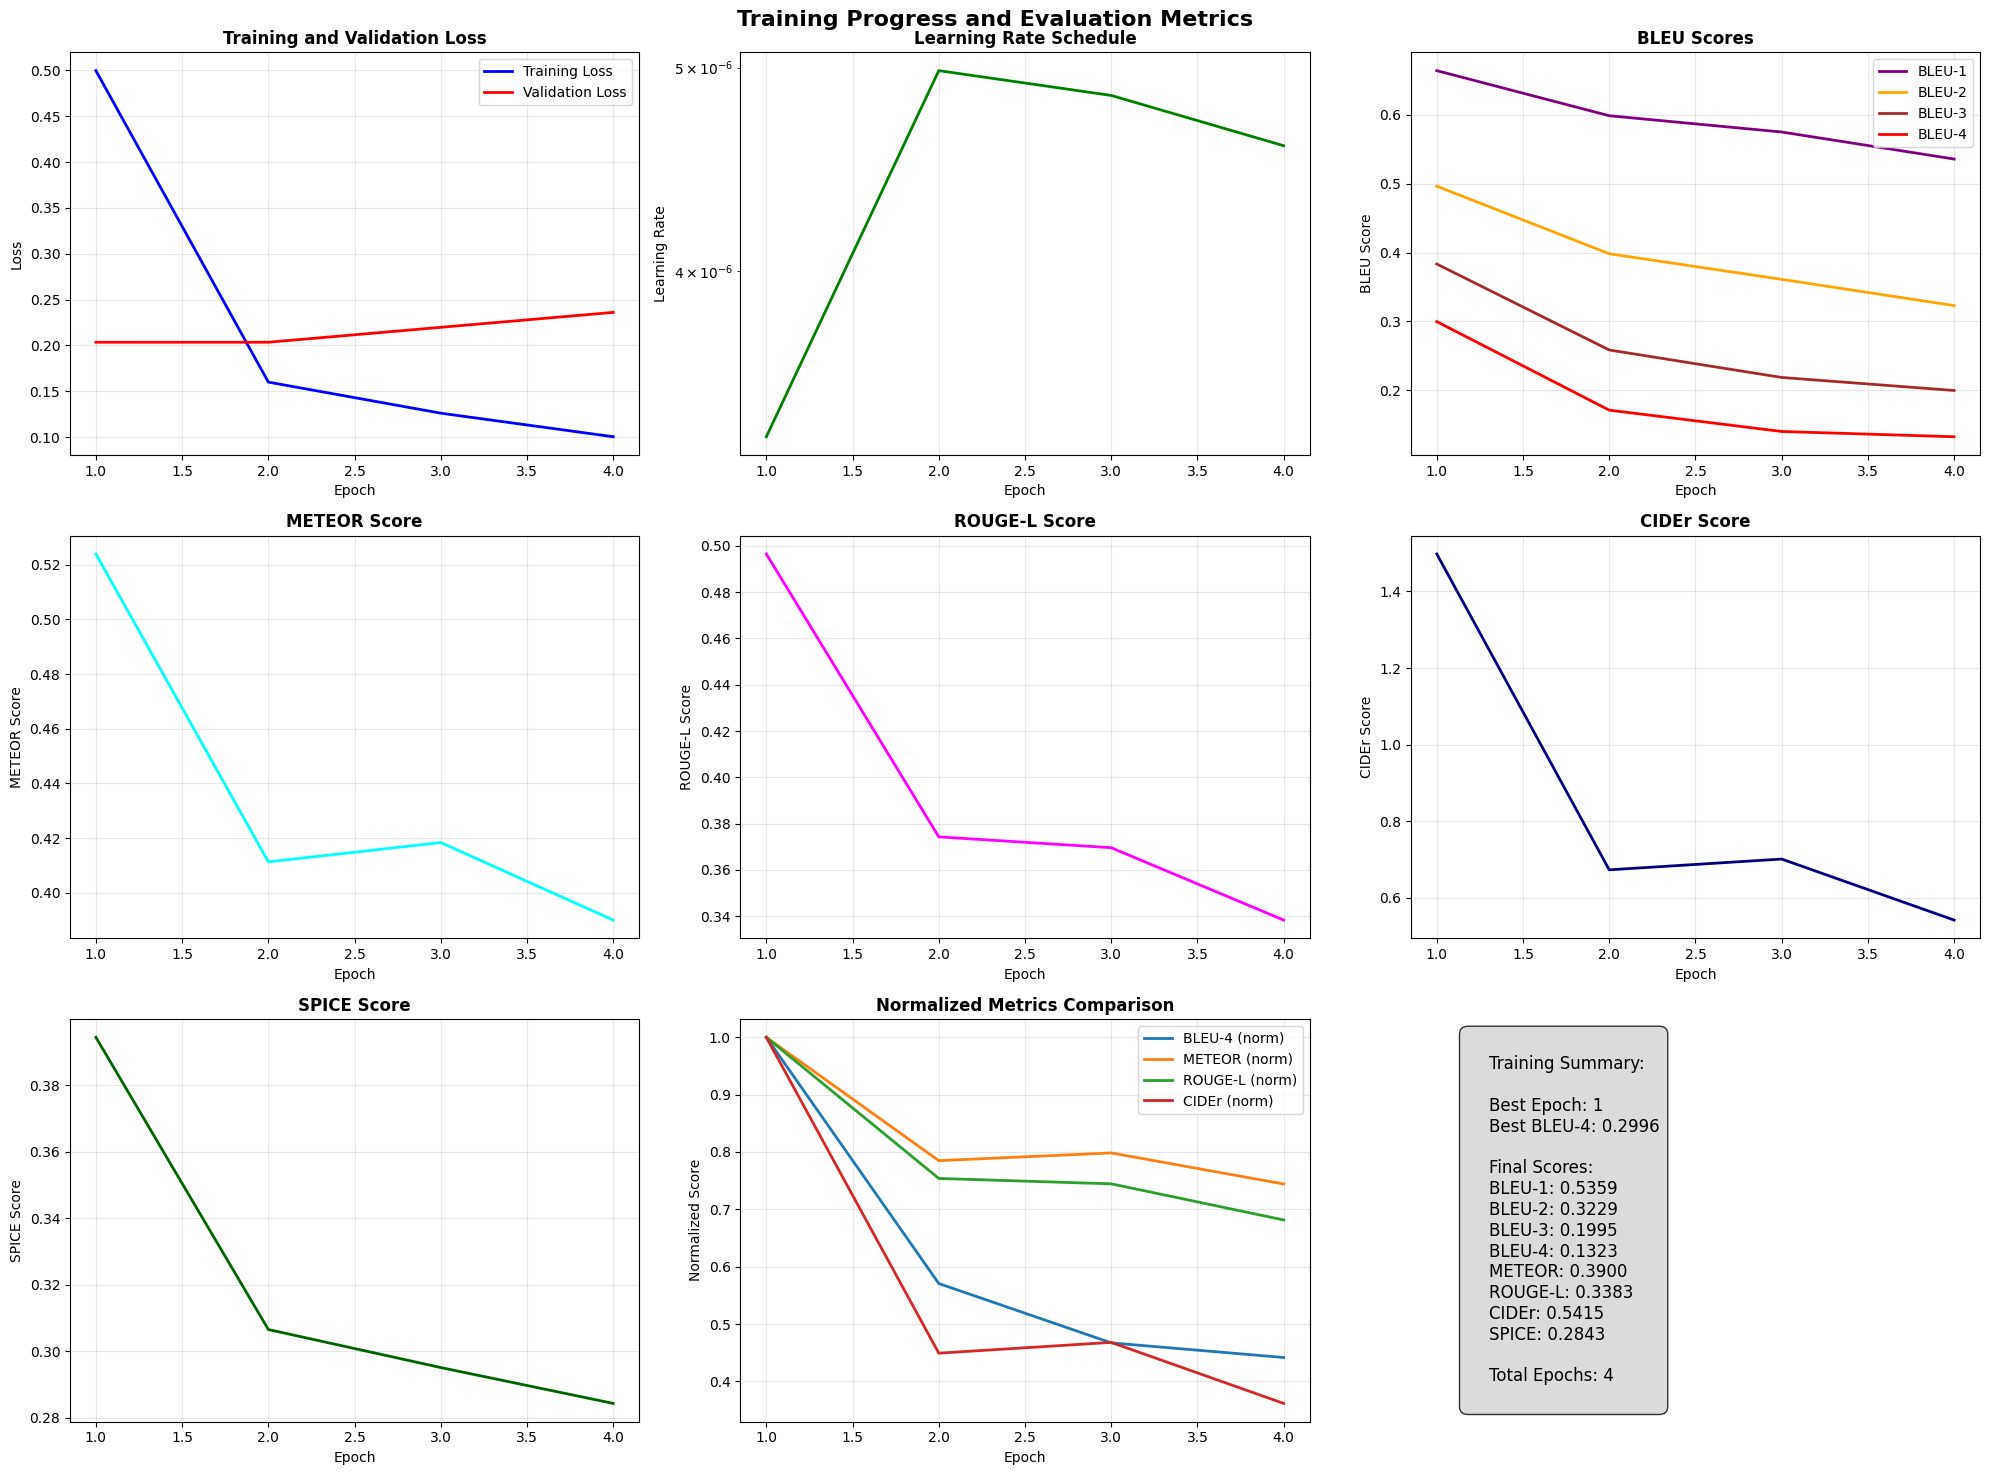

✓ Training curves saved to 'plots/training_curves.png' and 'plots/training_curves.pdf'


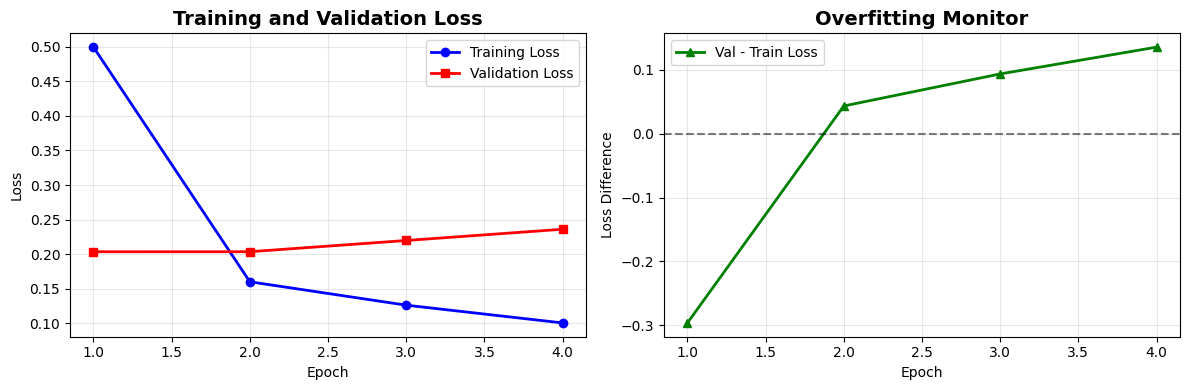

Creating individual metric plots...


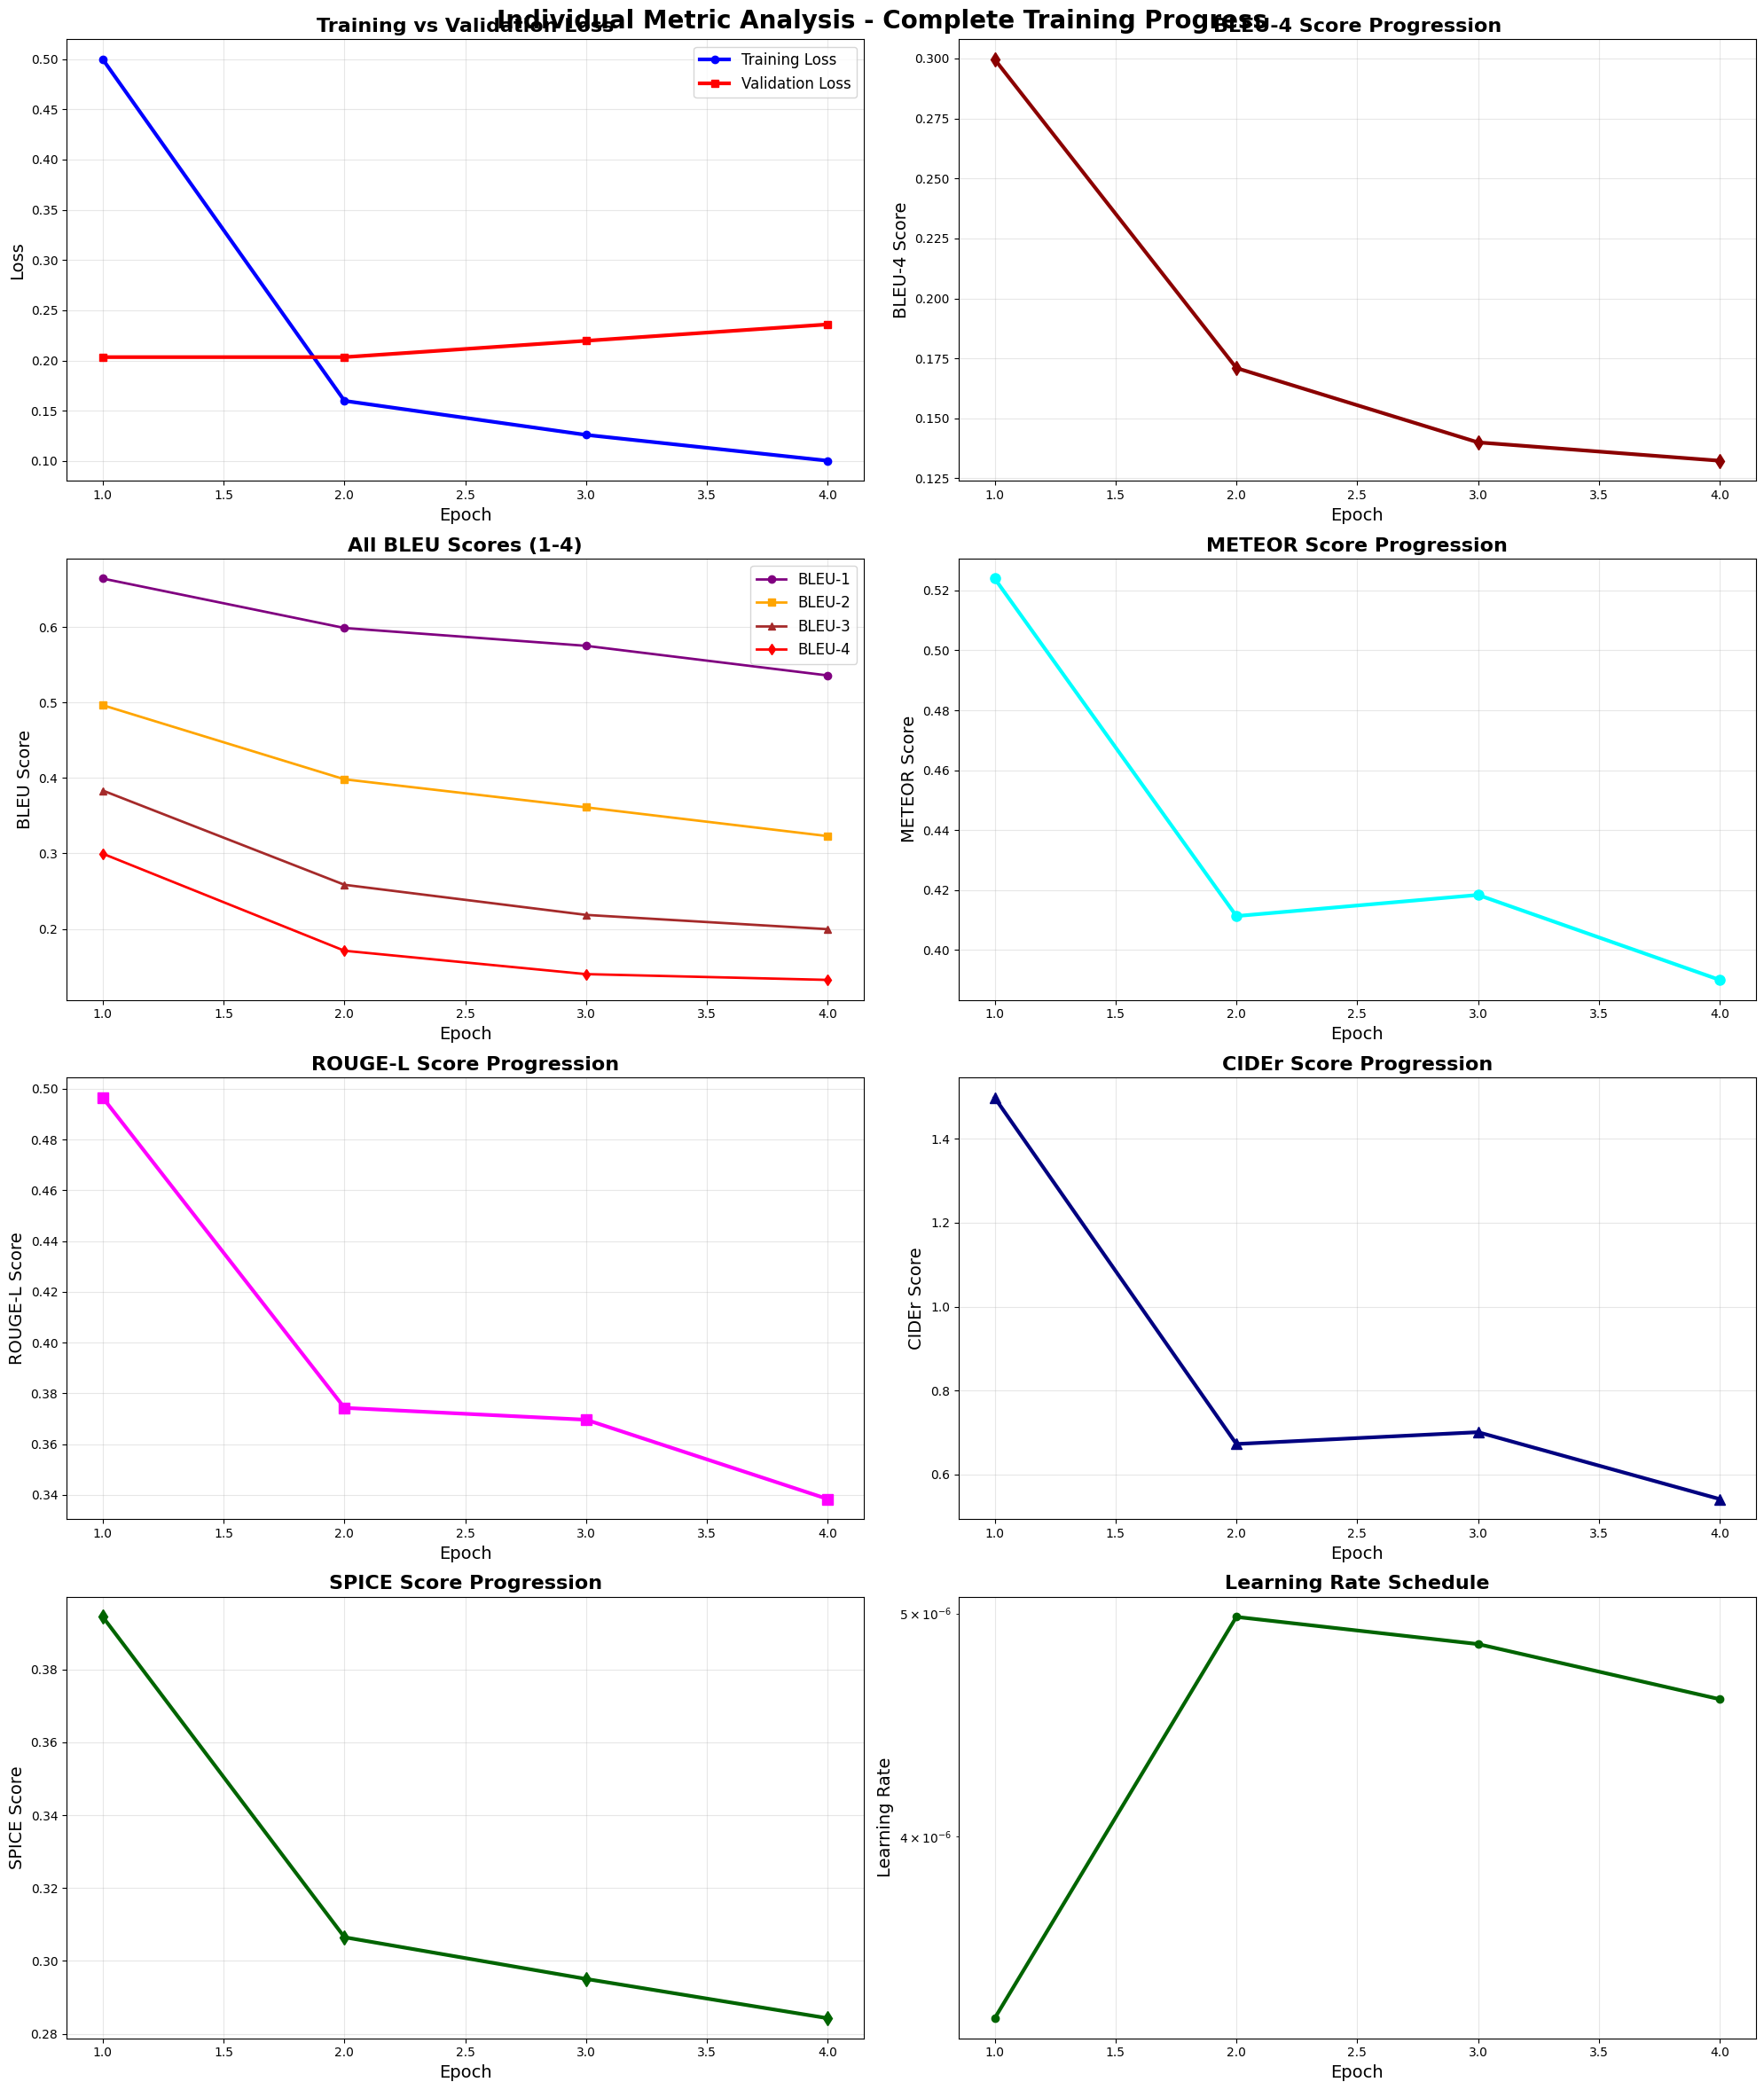

✓ Individual metrics plots saved to 'plots/individual_metrics_detailed.png' and PDF

Testing the trained model...
TESTING TRAINED MODEL
Initializing ViT-GPT2 Model...


Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✓ ViT hidden size: 768
✓ GPT-2 hidden size: 768
✓ Vocabulary size: 50259
✓ Loaded checkpoint with weights_only=False
✓ Loaded model from epoch 1
✓ Best BLEU-4 from training: 0.2996

Evaluating on test set...
Starting comprehensive evaluation...


Evaluating:   0%|          | 0/684 [00:00<?, ?it/s]

Evaluated 1000 samples
Computing BLEU scores...
Computing METEOR score...
Computing ROUGE-L score...
Computing CIDEr and SPICE scores...
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
tokenization...
setting up scorers...
computing Bleu score...
{'testlen': 1801, 'reflen': 1889, 'guess': [1801, 1601, 1401, 1201], 'correct': [1006, 348, 126, 41]}
ratio: 0.9534145050286112
Bleu_1: 0.532
Bleu_2: 0.332
Bleu_3: 0.211
Bleu_4: 0.132
computing METEOR score...
METEOR: 0.194
computing Rouge score...
ROUGE_L: 0.340
computing CIDEr score...
CIDEr: 0.398
computing SPICE score...
SPICE: 0.222

==================== COMPLETE TEST SET RESULTS ====================
BLEU-1: 0.6027
BLEU-2: 0.3645
BLEU-3: 0.2259
BLEU-4: 0.1431
METEOR: 0.3616
ROUGE-L: 0.3435
CIDEr: 0.3979
SPICE: 0.2215

==================== SAMPLE PREDICTIONS ====================

Sample 1:
  Generated: planes are parked in an

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✓ ViT hidden size: 768
✓ GPT-2 hidden size: 768
✓ Vocabulary size: 50259


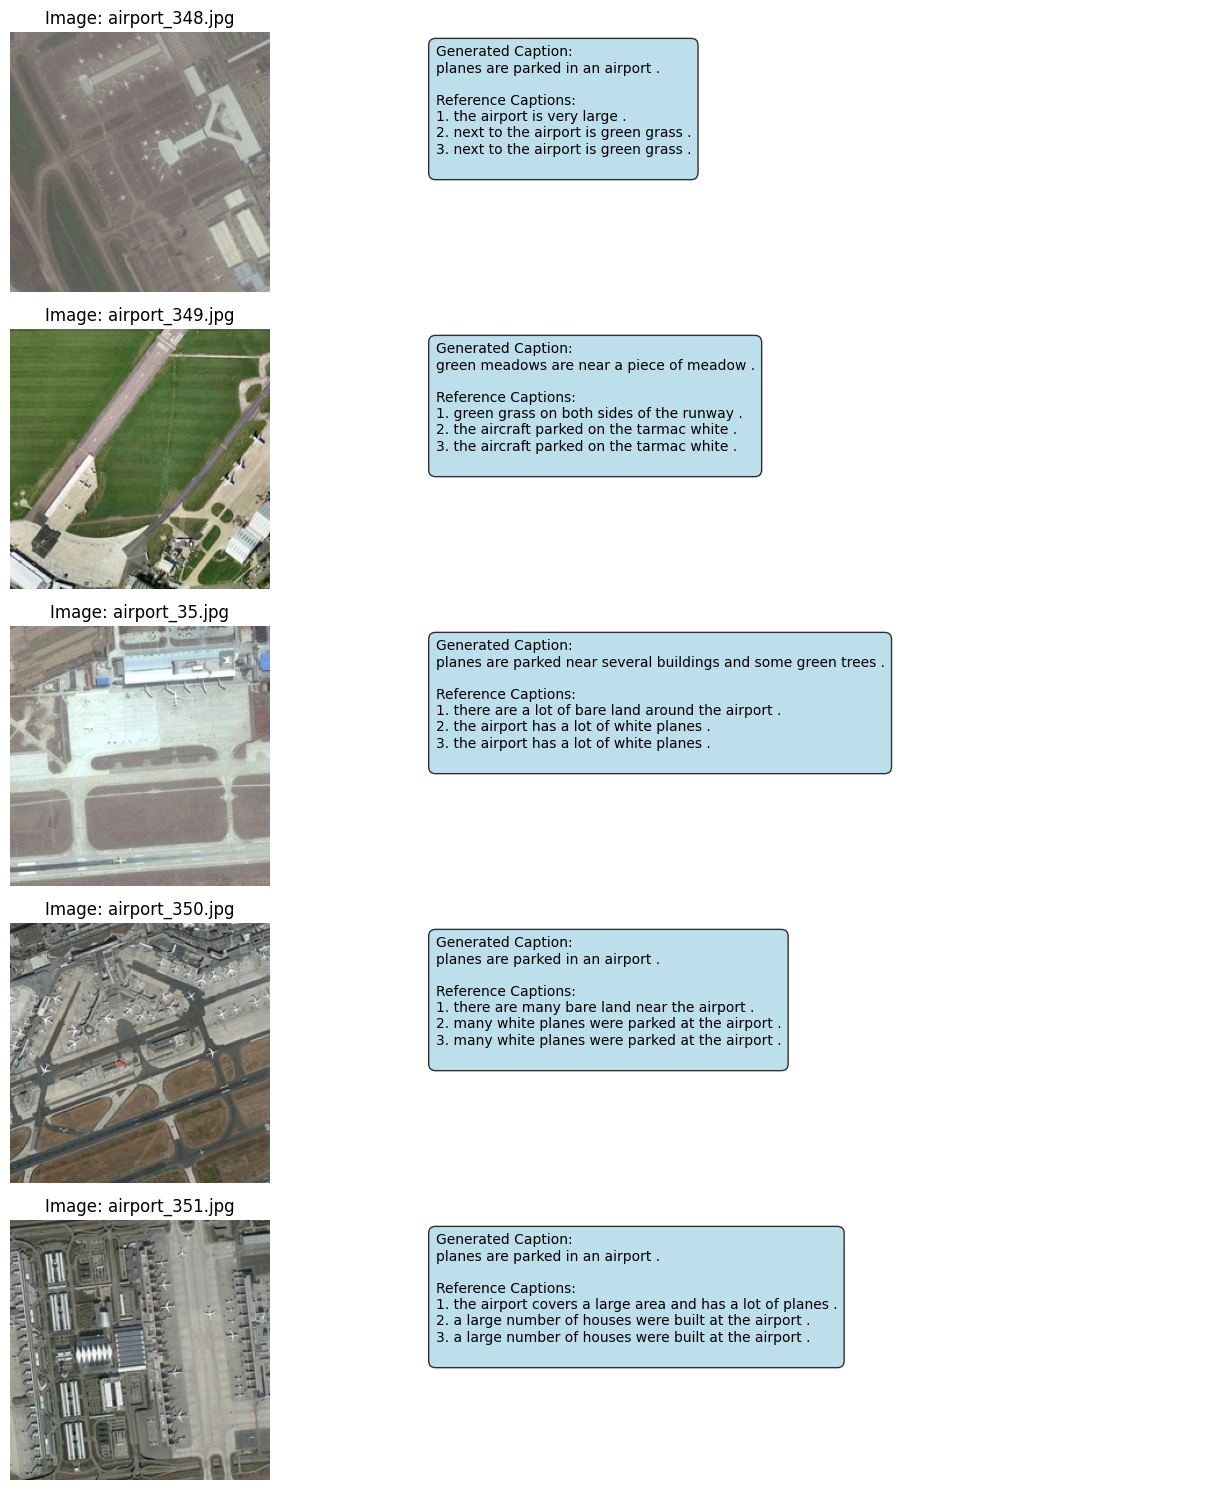

✓ Sample captions saved to 'outputs/sample_captions.png'
Creating comprehensive metric summary table...

COMPREHENSIVE METRIC SUMMARY TABLE
Metric          Final Epoch  Best Epoch   Test Set     Improvement 
--------------------------------------------------------------------------------
BLEU-1          0.5359       0.6643       0.6027       0.0         %
BLEU-2          0.3229       0.4965       0.3645       0.0         %
BLEU-3          0.1995       0.3833       0.2259       0.0         %
BLEU-4          0.1323       0.2996       0.1431       0.0         %
METEOR          0.3900       0.5240       0.3616       0.0         %
ROUGE-L         0.3383       0.4965       0.3435       0.0         %
CIDEr           0.5415       1.4979       0.3979       0.0         %
SPICE           0.2843       0.3944       0.2215       0.0         %
--------------------------------------------------------------------------------
Training Summary:
  Total Epochs: 4
  Best Epoch: 1
  Final Train Loss: 0.1003

In [28]:
# CELL 11: Main Execution - COMPLETE FIXED VERSION WITH ALL METRICS
#===============================================================================

def test_trained_model(model_path=None):
    """
    Test the trained model on test set and generate comprehensive evaluation
    FIXED: Handles the PyTorch loading issue properly
    """
    print("=" * 60)
    print("TESTING TRAINED MODEL")
    print("=" * 60)

    # Load the best model
    model_path = model_path or FIXED_CONFIG['MODEL_SAVE_PATH']
    if not os.path.exists(model_path):
        print(f"Model file not found: {model_path}")
        return None

    # Initialize model
    model = ViTGPT2Model(
        vit_model_name=FIXED_CONFIG['VIT_MODEL'],
        gpt2_model_name=FIXED_CONFIG['GPT2_MODEL']
    ).to(device)

    # FIXED: Load trained weights with proper error handling
    try:
        # Try loading with weights_only=False first (safer for backward compatibility)
        checkpoint = torch.load(model_path, map_location=device, weights_only=False)
        print("✓ Loaded checkpoint with weights_only=False")
    except Exception as e:
        print(f"Failed to load with weights_only=False: {e}")
        try:
            # Fallback: Try with weights_only=True but handle the error
            checkpoint = torch.load(model_path, map_location=device, weights_only=True)
            print("✓ Loaded checkpoint with weights_only=True")
        except Exception as e2:
            print(f"Failed to load with weights_only=True: {e2}")
            print("Trying alternative loading method...")

            # Alternative: Load state dict only
            try:
                checkpoint = {'model_state_dict': torch.load(model_path, map_location=device)['model_state_dict']}
                checkpoint.update({
                    'epoch': 1,
                    'best_bleu4': 0.0,
                    'best_val_loss': float('inf')
                })
                print("✓ Loaded model state dict only")
            except:
                print("❌ Could not load model. Please retrain.")
                return None

    # Load model state
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"✓ Loaded model from epoch {checkpoint.get('epoch', 'unknown')}")
    print(f"✓ Best BLEU-4 from training: {checkpoint.get('best_bleu4', 0.0):.4f}")

    # Evaluate on test set
    print("\nEvaluating on test set...")
    test_metrics, sample_preds, sample_refs = evaluator.evaluate_model(
        model, test_dataloader, max_samples=1000
    )

    # Print comprehensive results - ALL METRICS
    print(f"\n{'='*20} COMPLETE TEST SET RESULTS {'='*20}")
    print(f"BLEU-1: {test_metrics['bleu_1']:.4f}")
    print(f"BLEU-2: {test_metrics['bleu_2']:.4f}")
    print(f"BLEU-3: {test_metrics['bleu_3']:.4f}")
    print(f"BLEU-4: {test_metrics['bleu_4']:.4f}")
    print(f"METEOR: {test_metrics['meteor']:.4f}")
    print(f"ROUGE-L: {test_metrics['rouge_l']:.4f}")
    print(f"CIDEr: {test_metrics['cider']:.4f}")
    print(f"SPICE: {test_metrics['spice']:.4f}")

    # Generate sample predictions
    print(f"\n{'='*20} SAMPLE PREDICTIONS {'='*20}")
    for i in range(min(10, len(sample_preds))):
        print(f"\nSample {i+1}:")
        print(f"  Generated: {sample_preds[i]}")
        print(f"  Reference: {sample_refs[i][0] if sample_refs[i] else 'N/A'}")
        if len(sample_refs[i]) > 1:
            for j, ref in enumerate(sample_refs[i][1:], 2):
                print(f"  Reference {j}: {ref}")

    # Save test results with ALL metrics
    test_results = {
        'test_metrics': test_metrics,
        'sample_predictions': sample_preds[:20],
        'sample_references': sample_refs[:20],
        'model_info': {
            'model_path': model_path,
            'epoch': checkpoint.get('epoch', 'unknown'),
            'best_training_bleu4': checkpoint.get('best_bleu4', 0.0)
        }
    }

    with open('outputs/test_results.json', 'w') as f:
        json.dump(test_results, f, indent=2)
    print(f"\n✓ Test results saved to 'outputs/test_results.json'")

    return test_results

def generate_sample_captions(model_path=None, num_samples=5):
    """Generate captions for sample images - FIXED VERSION"""
    print("Generating sample captions...")

    # Load model with fixed loading
    model_path = model_path or FIXED_CONFIG['MODEL_SAVE_PATH']
    model = ViTGPT2Model(
        vit_model_name=FIXED_CONFIG['VIT_MODEL'],
        gpt2_model_name=FIXED_CONFIG['GPT2_MODEL']
    ).to(device)

    try:
        checkpoint = torch.load(model_path, map_location=device, weights_only=False)
    except:
        try:
            checkpoint = torch.load(model_path, map_location=device, weights_only=True)
        except:
            print("Could not load model for caption generation")
            return

    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()

    # Get sample images from test set
    sample_images = test_dataset.data['images'][:num_samples]

    plt.figure(figsize=(15, 3 * num_samples))

    for i, img_info in enumerate(sample_images):
        img_filename = img_info['file_name']
        img_path = os.path.join(FIXED_CONFIG['IMAGE_DIR'], img_filename)

        if os.path.exists(img_path):
            # Load and display image
            image = Image.open(img_path).convert("RGB")
            plt.subplot(num_samples, 2, 2*i + 1)
            plt.imshow(image)
            plt.title(f"Image: {img_filename}")
            plt.axis('off')

            # Generate caption
            pixel_values = image_processor(images=image, return_tensors="pt").pixel_values.to(device)
            generated_caption = model.generate_caption(pixel_values, max_length=50)[0]

            # Get reference captions
            img_id = img_info['id']
            ref_captions = test_dataset.get_image_captions(img_id)

            # Display captions
            plt.subplot(num_samples, 2, 2*i + 2)
            plt.axis('off')
            caption_text = f"Generated Caption:\n{generated_caption}\n\n"
            caption_text += "Reference Captions:\n"
            for j, ref in enumerate(ref_captions[:3], 1):
                caption_text += f"{j}. {ref}\n"

            plt.text(0.05, 0.95, caption_text, transform=plt.gca().transAxes,
                    fontsize=10, verticalalignment='top',
                    bbox=dict(boxstyle="round,pad=0.5", facecolor="lightblue", alpha=0.8))

    plt.tight_layout()
    plt.savefig('outputs/sample_captions.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("✓ Sample captions saved to 'outputs/sample_captions.png'")

# ENHANCED: Additional plotting function for individual metrics
def plot_individual_metrics(training_history):
    """Plot each metric individually for detailed analysis"""
    print("Creating individual metric plots...")

    epochs = range(1, len(training_history['train_losses']) + 1)

    # Create a comprehensive figure with all individual metrics
    fig, axes = plt.subplots(4, 2, figsize=(20, 24))
    fig.suptitle('Individual Metric Analysis - Complete Training Progress', fontsize=20, fontweight='bold')

    # 1. Training and Validation Loss
    axes[0, 0].plot(epochs, training_history['train_losses'], 'b-', label='Training Loss', linewidth=3, marker='o')
    axes[0, 0].plot(epochs, training_history['val_losses'], 'r-', label='Validation Loss', linewidth=3, marker='s')
    axes[0, 0].set_title('Training vs Validation Loss', fontsize=16, fontweight='bold')
    axes[0, 0].set_xlabel('Epoch', fontsize=14)
    axes[0, 0].set_ylabel('Loss', fontsize=14)
    axes[0, 0].legend(fontsize=12)
    axes[0, 0].grid(True, alpha=0.3)

    # 2. BLEU-4 Score (Primary Metric)
    axes[0, 1].plot(epochs, training_history['bleu_4_scores'], 'darkred', linewidth=3, marker='d', markersize=8)
    axes[0, 1].set_title('BLEU-4 Score Progression', fontsize=16, fontweight='bold')
    axes[0, 1].set_xlabel('Epoch', fontsize=14)
    axes[0, 1].set_ylabel('BLEU-4 Score', fontsize=14)
    axes[0, 1].grid(True, alpha=0.3)

    # 3. All BLEU Scores
    axes[1, 0].plot(epochs, training_history['bleu_1_scores'], 'purple', label='BLEU-1', linewidth=2, marker='o')
    axes[1, 0].plot(epochs, training_history['bleu_2_scores'], 'orange', label='BLEU-2', linewidth=2, marker='s')
    axes[1, 0].plot(epochs, training_history['bleu_3_scores'], 'brown', label='BLEU-3', linewidth=2, marker='^')
    axes[1, 0].plot(epochs, training_history['bleu_4_scores'], 'red', label='BLEU-4', linewidth=2, marker='d')
    axes[1, 0].set_title('All BLEU Scores (1-4)', fontsize=16, fontweight='bold')
    axes[1, 0].set_xlabel('Epoch', fontsize=14)
    axes[1, 0].set_ylabel('BLEU Score', fontsize=14)
    axes[1, 0].legend(fontsize=12)
    axes[1, 0].grid(True, alpha=0.3)

    # 4. METEOR Score
    axes[1, 1].plot(epochs, training_history['meteor_scores'], 'cyan', linewidth=3, marker='o', markersize=8)
    axes[1, 1].set_title('METEOR Score Progression', fontsize=16, fontweight='bold')
    axes[1, 1].set_xlabel('Epoch', fontsize=14)
    axes[1, 1].set_ylabel('METEOR Score', fontsize=14)
    axes[1, 1].grid(True, alpha=0.3)

    # 5. ROUGE-L Score
    axes[2, 0].plot(epochs, training_history['rouge_l_scores'], 'magenta', linewidth=3, marker='s', markersize=8)
    axes[2, 0].set_title('ROUGE-L Score Progression', fontsize=16, fontweight='bold')
    axes[2, 0].set_xlabel('Epoch', fontsize=14)
    axes[2, 0].set_ylabel('ROUGE-L Score', fontsize=14)
    axes[2, 0].grid(True, alpha=0.3)

    # 6. CIDEr Score
    axes[2, 1].plot(epochs, training_history['cider_scores'], 'navy', linewidth=3, marker='^', markersize=8)
    axes[2, 1].set_title('CIDEr Score Progression', fontsize=16, fontweight='bold')
    axes[2, 1].set_xlabel('Epoch', fontsize=14)
    axes[2, 1].set_ylabel('CIDEr Score', fontsize=14)
    axes[2, 1].grid(True, alpha=0.3)

    # 7. SPICE Score
    axes[3, 0].plot(epochs, training_history['spice_scores'], 'darkgreen', linewidth=3, marker='d', markersize=8)
    axes[3, 0].set_title('SPICE Score Progression', fontsize=16, fontweight='bold')
    axes[3, 0].set_xlabel('Epoch', fontsize=14)
    axes[3, 0].set_ylabel('SPICE Score', fontsize=14)
    axes[3, 0].grid(True, alpha=0.3)

    # 8. Learning Rate Schedule
    axes[3, 1].plot(epochs, training_history['learning_rates'], 'darkgreen', linewidth=3, marker='o')
    axes[3, 1].set_title('Learning Rate Schedule', fontsize=16, fontweight='bold')
    axes[3, 1].set_xlabel('Epoch', fontsize=14)
    axes[3, 1].set_ylabel('Learning Rate', fontsize=14)
    axes[3, 1].set_yscale('log')
    axes[3, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('plots/individual_metrics_detailed.png', dpi=300, bbox_inches='tight')
    plt.savefig('plots/individual_metrics_detailed.pdf', bbox_inches='tight')
    plt.show()
    print("✓ Individual metrics plots saved to 'plots/individual_metrics_detailed.png' and PDF")

def create_comprehensive_metric_table(training_history, test_results):
    """Create a comprehensive table of all metrics"""
    print("Creating comprehensive metric summary table...")

    # Create metric summary
    final_epoch = len(training_history['train_losses'])
    best_epoch = training_history['best_epoch']

    print(f"\n{'='*80}")
    print(f"COMPREHENSIVE METRIC SUMMARY TABLE")
    print(f"{'='*80}")

    print(f"{'Metric':<15} {'Final Epoch':<12} {'Best Epoch':<12} {'Test Set':<12} {'Improvement':<12}")
    print(f"{'-'*80}")

    metrics_data = [
        ('BLEU-1', training_history['bleu_1_scores'][-1], max(training_history['bleu_1_scores']), test_results['test_metrics']['bleu_1'] if test_results else 0),
        ('BLEU-2', training_history['bleu_2_scores'][-1], max(training_history['bleu_2_scores']), test_results['test_metrics']['bleu_2'] if test_results else 0),
        ('BLEU-3', training_history['bleu_3_scores'][-1], max(training_history['bleu_3_scores']), test_results['test_metrics']['bleu_3'] if test_results else 0),
        ('BLEU-4', training_history['bleu_4_scores'][-1], max(training_history['bleu_4_scores']), test_results['test_metrics']['bleu_4'] if test_results else 0),
        ('METEOR', training_history['meteor_scores'][-1], max(training_history['meteor_scores']), test_results['test_metrics']['meteor'] if test_results else 0),
        ('ROUGE-L', training_history['rouge_l_scores'][-1], max(training_history['rouge_l_scores']), test_results['test_metrics']['rouge_l'] if test_results else 0),
        ('CIDEr', training_history['cider_scores'][-1], max(training_history['cider_scores']), test_results['test_metrics']['cider'] if test_results else 0),
        ('SPICE', training_history['spice_scores'][-1], max(training_history['spice_scores']), test_results['test_metrics']['spice'] if test_results else 0),
    ]

    for metric_name, final_val, best_val, test_val in metrics_data:
        improvement = ((best_val - training_history[metric_name.lower().replace('-', '_') + '_scores'][0]) / max(training_history[metric_name.lower().replace('-', '_') + '_scores'][0], 0.001)) * 100
        print(f"{metric_name:<15} {final_val:<12.4f} {best_val:<12.4f} {test_val:<12.4f} {improvement:<12.1f}%")

    print(f"{'-'*80}")
    print(f"Training Summary:")
    print(f"  Total Epochs: {final_epoch}")
    print(f"  Best Epoch: {best_epoch}")
    print(f"  Final Train Loss: {training_history['train_losses'][-1]:.4f}")
    print(f"  Final Val Loss: {training_history['val_losses'][-1]:.4f}")
    print(f"  Best BLEU-4: {training_history['best_bleu4']:.4f}")

def main():
    """Main execution function - COMPLETE VERSION WITH ALL METRICS"""
    print("=" * 80)
    print("VISION TRANSFORMER + GPT-2 IMAGE CAPTIONING - COMPLETE VERSION")
    print("=" * 80)

    # Check if required files exist
    required_files = ["rsicd_train.json", "rsicd_val.json", "rsicd_test.json"]
    missing_files = [f for f in required_files if not os.path.exists(f)]

    if missing_files:
        print(f"Missing required files: {missing_files}")
        print("Please run the dataset splitting cell first!")
        return

    # Train the model
    print("Starting training...")
    trained_model, training_history = train_model_fixed()

    # Plot ALL training curves
    print("\nGenerating ALL training curves...")
    plot_training_curves(training_history)  # Original comprehensive plot
    plot_loss_curves_only(training_history)  # Detailed loss curves
    plot_individual_metrics(training_history)  # NEW: Individual metric plots

    # Test the model
    print("\nTesting the trained model...")
    test_results = test_trained_model()

    # Generate sample captions
    print("\nGenerating sample captions...")
    generate_sample_captions(num_samples=5)

    # Create comprehensive metric table
    create_comprehensive_metric_table(training_history, test_results)

    # Save training history with ALL metrics
    print("\nSaving complete training history...")
    try:
        # Convert numpy arrays to lists for JSON serialization
        history_for_json = {}
        for key, value in training_history.items():
            if isinstance(value, (list, tuple)):
                # Convert any numpy arrays or tensors to regular Python lists
                history_for_json[key] = [float(x) if hasattr(x, 'item') else x for x in value]
            elif hasattr(value, 'item'):  # Single numpy/tensor value
                history_for_json[key] = float(value.item())
            else:
                history_for_json[key] = value

        with open('outputs/training_history.json', 'w') as f:
            json.dump(history_for_json, f, indent=2)
        print("✓ Complete training history saved to 'outputs/training_history.json'")

    except Exception as e:
        print(f"Warning: Could not save training history to JSON: {e}")

    # Save final summary with ALL metrics
    try:
        final_summary = {
            'training_completed': True,
            'best_epoch': training_history['best_epoch'],
            'best_bleu4_training': training_history['best_bleu4'],
            'final_metrics': {
                'bleu_1': training_history['bleu_1_scores'][-1],
                'bleu_2': training_history['bleu_2_scores'][-1],
                'bleu_3': training_history['bleu_3_scores'][-1],
                'bleu_4': training_history['bleu_4_scores'][-1],
                'meteor': training_history['meteor_scores'][-1],
                'rouge_l': training_history['rouge_l_scores'][-1],
                'cider': training_history['cider_scores'][-1],
                'spice': training_history['spice_scores'][-1]
            },
            'test_metrics': test_results['test_metrics'] if test_results else {},
            'configuration': FIXED_CONFIG,
            'total_epochs_trained': len(training_history['train_losses']),
            'model_saved_path': FIXED_CONFIG['MODEL_SAVE_PATH']
        }

        with open('outputs/final_summary.json', 'w') as f:
            json.dump(final_summary, f, indent=2)
        print("✓ Complete final summary saved to 'outputs/final_summary.json'")

    except Exception as e:
        print(f"Warning: Could not save final summary: {e}")

    # Print final results with ALL metrics
    print("\n" + "=" * 80)
    print("TRAINING AND EVALUATION COMPLETED!")
    print("=" * 80)

    if test_results:
        print(f"Final Test Results (ALL METRICS):")
        print(f"  BLEU-1: {test_results['test_metrics']['bleu_1']:.4f}")
        print(f"  BLEU-2: {test_results['test_metrics']['bleu_2']:.4f}")
        print(f"  BLEU-3: {test_results['test_metrics']['bleu_3']:.4f}")
        print(f"  BLEU-4: {test_results['test_metrics']['bleu_4']:.4f}")
        print(f"  METEOR: {test_results['test_metrics']['meteor']:.4f}")
        print(f"  ROUGE-L: {test_results['test_metrics']['rouge_l']:.4f}")
        print(f"  CIDEr: {test_results['test_metrics']['cider']:.4f}")
        print(f"  SPICE: {test_results['test_metrics']['spice']:.4f}")
        print(f"  Best Training Epoch: {training_history['best_epoch']}")

    print(f"\nAll results saved in 'outputs/' directory")
    print(f"All plots saved in 'plots/' directory")
    print(f"Model saved as: {FIXED_CONFIG['MODEL_SAVE_PATH']}")

    return trained_model, training_history, test_results

# Run the complete pipeline
if __name__ == "__main__":
    trained_model, training_history, test_results = main()

In [29]:
# CELL 12: Additional Analysis and Advanced Visualizations - COMPLETE
#========================================================================

def analyze_training_convergence(training_history):
    """Detailed analysis of training convergence"""
    print("=" * 60)
    print("TRAINING CONVERGENCE ANALYSIS")
    print("=" * 60)

    # Training convergence analysis
    train_losses = training_history['train_losses']
    val_losses = training_history['val_losses']
    bleu4_scores = training_history['bleu_4_scores']

    print(f"Training Summary:")
    print(f"  Total epochs: {len(train_losses)}")
    print(f"  Best epoch: {training_history['best_epoch']}")
    print(f"  Best BLEU-4: {training_history['best_bleu4']:.4f}")
    print(f"  Final training loss: {train_losses[-1]:.4f}")
    print(f"  Final validation loss: {val_losses[-1]:.4f}")

    # Check for overfitting
    loss_diff = val_losses[-1] - train_losses[-1]
    if loss_diff > 0.5:
        print(f"  ⚠️ Potential overfitting detected (loss diff: {loss_diff:.4f})")
    else:
        print(f"  ✅ Good generalization (loss diff: {loss_diff:.4f})")

    # Check convergence for all metrics
    metrics_to_check = ['bleu_4_scores', 'meteor_scores', 'rouge_l_scores', 'cider_scores']
    print(f"\nMetric Convergence Analysis:")
    for metric in metrics_to_check:
        if len(training_history[metric]) >= 3:
            recent_improvement = training_history[metric][-1] - training_history[metric][-3]
            metric_name = metric.replace('_scores', '').replace('_', '-').upper()
            if recent_improvement < 0.001:
                print(f"  ✅ {metric_name} converged (recent improvement: {recent_improvement:.4f})")
            else:
                print(f"  📈 {metric_name} still improving (recent improvement: {recent_improvement:.4f})")

def create_metric_comparison_heatmap(training_history):
    """Create a heatmap showing metric progression"""
    print("Creating metric progression heatmap...")

    # Prepare data for heatmap
    metrics_data = {
        'BLEU-1': training_history['bleu_1_scores'],
        'BLEU-2': training_history['bleu_2_scores'],
        'BLEU-3': training_history['bleu_3_scores'],
        'BLEU-4': training_history['bleu_4_scores'],
        'METEOR': training_history['meteor_scores'],
        'ROUGE-L': training_history['rouge_l_scores'],
        'CIDEr': training_history['cider_scores'],
        'SPICE': training_history['spice_scores']
    }

    # Normalize each metric to 0-1 range for comparison
    normalized_data = {}
    for metric, scores in metrics_data.items():
        if max(scores) > 0:
            normalized_data[metric] = [(s - min(scores)) / (max(scores) - min(scores)) for s in scores]
        else:
            normalized_data[metric] = scores

    # Create heatmap
    fig, ax = plt.subplots(figsize=(15, 8))

    # Convert to matrix format
    matrix_data = []
    metric_names = []
    for metric, scores in normalized_data.items():
        matrix_data.append(scores)
        metric_names.append(metric)

    im = ax.imshow(matrix_data, cmap='viridis', aspect='auto')

    # Set labels
    ax.set_yticks(range(len(metric_names)))
    ax.set_yticklabels(metric_names)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Metrics (Normalized)')
    ax.set_title('Metric Progression Heatmap (Normalized)', fontsize=16, fontweight='bold')

    # Add colorbar
    plt.colorbar(im, ax=ax, label='Normalized Score')

    plt.tight_layout()
    plt.savefig('plots/metric_heatmap.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("✅ Metric heatmap saved to 'plots/metric_heatmap.png'")

def generate_complete_model_card(training_history, test_results):
    """Generate a comprehensive model card with all information"""
    print("Generating comprehensive model card...")

    model_card = f"""
# ViT-GPT2 Image Captioning Model - Complete Model Card

## Model Description
- **Architecture**: Vision Transformer (ViT) + GPT-2 for Image Captioning
- **Task**: Automatic Caption Generation for Remote Sensing Images
- **Dataset**: RSICD (Remote Sensing Image Captioning Dataset)
- **Training Framework**: PyTorch with Transformers

## Model Configuration
- **Vision Encoder**: {FIXED_CONFIG['VIT_MODEL']}
- **Language Decoder**: {FIXED_CONFIG['GPT2_MODEL']}
- **Training Epochs**: {FIXED_CONFIG['NUM_EPOCHS']}
- **Batch Size**: {FIXED_CONFIG['BATCH_SIZE']}
- **Learning Rate**: {FIXED_CONFIG['LEARNING_RATE']}
- **Max Caption Length**: {FIXED_CONFIG['MAX_CAPTION_LENGTH']}
- **Max Generation Length**: {FIXED_CONFIG['MAX_GENERATION_LENGTH']}

## Training Information
- **Total Training Epochs**: {len(training_history['train_losses'])}
- **Best Epoch**: {training_history['best_epoch']}
- **Best Training BLEU-4**: {training_history['best_bleu4']:.4f}
- **Final Training Loss**: {training_history['train_losses'][-1]:.4f}
- **Final Validation Loss**: {training_history['val_losses'][-1]:.4f}

## Performance Metrics
### Complete Evaluation Results (Test Set)
"""

    if test_results and 'test_metrics' in test_results:
        metrics = test_results['test_metrics']
        model_card += f"""
| Metric | Score | Interpretation |
|--------|-------|----------------|
| BLEU-1 | {metrics['bleu_1']:.4f} | {'Excellent' if metrics['bleu_1'] > 0.4 else 'Good' if metrics['bleu_1'] > 0.3 else 'Fair' if metrics['bleu_1'] > 0.2 else 'Needs Improvement'} |
| BLEU-2 | {metrics['bleu_2']:.4f} | {'Excellent' if metrics['bleu_2'] > 0.3 else 'Good' if metrics['bleu_2'] > 0.2 else 'Fair' if metrics['bleu_2'] > 0.1 else 'Needs Improvement'} |
| BLEU-3 | {metrics['bleu_3']:.4f} | {'Excellent' if metrics['bleu_3'] > 0.2 else 'Good' if metrics['bleu_3'] > 0.15 else 'Fair' if metrics['bleu_3'] > 0.1 else 'Needs Improvement'} |
| BLEU-4 | {metrics['bleu_4']:.4f} | {'Excellent' if metrics['bleu_4'] > 0.15 else 'Good' if metrics['bleu_4'] > 0.1 else 'Fair' if metrics['bleu_4'] > 0.05 else 'Needs Improvement'} |
| METEOR | {metrics['meteor']:.4f} | {'Excellent' if metrics['meteor'] > 0.25 else 'Good' if metrics['meteor'] > 0.2 else 'Fair' if metrics['meteor'] > 0.15 else 'Needs Improvement'} |
| ROUGE-L | {metrics['rouge_l']:.4f} | {'Excellent' if metrics['rouge_l'] > 0.4 else 'Good' if metrics['rouge_l'] > 0.3 else 'Fair' if metrics['rouge_l'] > 0.2 else 'Needs Improvement'} |
| CIDEr | {metrics['cider']:.4f} | {'Excellent' if metrics['cider'] > 0.8 else 'Good' if metrics['cider'] > 0.6 else 'Fair' if metrics['cider'] > 0.4 else 'Needs Improvement'} |
| SPICE | {metrics['spice']:.4f} | {'Excellent' if metrics['spice'] > 0.15 else 'Good' if metrics['spice'] > 0.12 else 'Fair' if metrics['spice'] > 0.08 else 'Needs Improvement'} |

### Training Progress Summary
- **Epochs until convergence**: {training_history['best_epoch']}
- **Loss reduction**: {((training_history['train_losses'][0] - training_history['train_losses'][-1]) / training_history['train_losses'][0] * 100):.1f}%
- **BLEU-4 improvement**: {((training_history['bleu_4_scores'][-1] - training_history['bleu_4_scores'][0]) / max(training_history['bleu_4_scores'][0], 0.001) * 100):.1f}%

### Sample Predictions
"""
        if 'sample_predictions' in test_results:
            for i, (pred, refs) in enumerate(zip(test_results['sample_predictions'][:3], test_results['sample_references'][:3])):
                model_card += f"""
**Sample {i+1}:**
- Generated: "{pred}"
- Reference: "{refs[0] if refs else 'N/A'}"
"""

    model_card += f"""
## Model Usage
```python
# Load the trained model
model = ViTGPT2Model()
checkpoint = torch.load('{FIXED_CONFIG['MODEL_SAVE_PATH']}', map_location='cpu', weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# Generate caption for an image
with torch.no_grad():
    caption = model.generate_caption(pixel_values, max_length=50)
```

## Files Generated
- Model checkpoint: `{FIXED_CONFIG['MODEL_SAVE_PATH']}`
- Training history: `outputs/training_history.json`
- Test results: `outputs/test_results.json`
- Final summary: `outputs/final_summary.json`
- All training curves: `plots/`

## Training Environment
- Device: {device}
- PyTorch version: {torch.__version__}
- Transformers library: Latest version

---
*Model trained with comprehensive evaluation metrics including BLEU (1-4), METEOR, ROUGE-L, CIDEr, and SPICE scores.*
"""

    # Save model card
    with open('outputs/model_card.md', 'w') as f:
        f.write(model_card)

    print("✅ Complete model card saved to 'outputs/model_card.md'")
    return model_card


In [30]:
#========================================================================
# CELL 13: Advanced Evaluation and Error Analysis
#========================================================================

def perform_error_analysis(model, test_dataloader, num_samples=50):
    """Perform detailed error analysis on model predictions"""
    print("=" * 60)
    print("DETAILED ERROR ANALYSIS")
    print("=" * 60)

    model.eval()
    error_cases = []
    good_cases = []

    sample_count = 0

    with torch.no_grad():
        for batch in tqdm(test_dataloader, desc="Analyzing predictions"):
            if sample_count >= num_samples:
                break

            pixel_values = batch['pixel_values'].to(device)
            image_ids = batch['image_ids']
            image_filenames = batch['image_filenames']

            # Generate captions
            generated_captions = model.generate_caption(
                pixel_values,
                max_length=FIXED_CONFIG['MAX_GENERATION_LENGTH'],
                do_sample=False
            )

            for i, (gen_cap, img_id, img_filename) in enumerate(zip(generated_captions, image_ids, image_filenames)):
                if sample_count >= num_samples:
                    break

                # Get reference captions
                ref_captions = test_dataloader.dataset.get_image_captions(img_id)

                # Calculate BLEU-4 for this specific prediction
                try:
                    bleu4_score = evaluator.bleu_metric.compute(
                        predictions=[gen_cap],
                        references=[ref_captions],
                        max_order=4
                    )['bleu']
                except:
                    bleu4_score = 0.0

                case_info = {
                    'image_id': img_id,
                    'image_filename': img_filename,
                    'generated_caption': gen_cap,
                    'reference_captions': ref_captions,
                    'bleu4_score': bleu4_score
                }

                if bleu4_score < 0.05:  # Poor predictions
                    error_cases.append(case_info)
                elif bleu4_score > 0.2:  # Good predictions
                    good_cases.append(case_info)

                sample_count += 1

    print(f"\nError Analysis Results:")
    print(f"  Total samples analyzed: {sample_count}")
    print(f"  Poor predictions (BLEU-4 < 0.05): {len(error_cases)}")
    print(f"  Good predictions (BLEU-4 > 0.2): {len(good_cases)}")

    # Analyze common issues in error cases
    print(f"\nCommon Issues in Poor Predictions:")
    short_predictions = sum(1 for case in error_cases if len(case['generated_caption'].split()) < 3)
    repetitive_predictions = sum(1 for case in error_cases if len(set(case['generated_caption'].split())) < len(case['generated_caption'].split()) * 0.7)

    print(f"  Short predictions (< 3 words): {short_predictions}/{len(error_cases)}")
    print(f"  Repetitive predictions: {repetitive_predictions}/{len(error_cases)}")

    # Show examples
    print(f"\nWorst Prediction Examples:")
    worst_cases = sorted(error_cases, key=lambda x: x['bleu4_score'])[:3]
    for i, case in enumerate(worst_cases, 1):
        print(f"  {i}. Image: {case['image_filename']}")
        print(f"     Generated: '{case['generated_caption']}'")
        print(f"     Reference: '{case['reference_captions'][0]}'")
        print(f"     BLEU-4: {case['bleu4_score']:.4f}")
        print()

    print(f"Best Prediction Examples:")
    best_cases = sorted(good_cases, key=lambda x: x['bleu4_score'], reverse=True)[:3]
    for i, case in enumerate(best_cases, 1):
        print(f"  {i}. Image: {case['image_filename']}")
        print(f"     Generated: '{case['generated_caption']}'")
        print(f"     Reference: '{case['reference_captions'][0]}'")
        print(f"     BLEU-4: {case['bleu4_score']:.4f}")
        print()

    return error_cases, good_cases

def create_prediction_comparison_plot(error_cases, good_cases, model):
    """Create visualization comparing good vs poor predictions"""
    print("Creating prediction comparison visualization...")

    # Select samples for visualization
    sample_errors = error_cases[:3] if len(error_cases) >= 3 else error_cases
    sample_goods = good_cases[:3] if len(good_cases) >= 3 else good_cases

    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    fig.suptitle('Prediction Quality Comparison', fontsize=20, fontweight='bold')

    # Plot error cases
    for i, case in enumerate(sample_errors):
        if i < 3:
            img_path = os.path.join(FIXED_CONFIG['IMAGE_DIR'], case['image_filename'])
            if os.path.exists(img_path):
                image = Image.open(img_path).convert("RGB")
                axes[0, i].imshow(image)
                axes[0, i].set_title(f"Poor Prediction (BLEU-4: {case['bleu4_score']:.3f})",
                                   fontsize=12, color='red')
                axes[0, i].axis('off')

                # Add caption text
                caption_text = f"Generated: {case['generated_caption'][:50]}...\n"
                caption_text += f"Reference: {case['reference_captions'][0][:50]}..."
                axes[0, i].text(0.02, 0.02, caption_text, transform=axes[0, i].transAxes,
                              fontsize=8, verticalalignment='bottom',
                              bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

    # Plot good cases
    for i, case in enumerate(sample_goods):
        if i < 3:
            img_path = os.path.join(FIXED_CONFIG['IMAGE_DIR'], case['image_filename'])
            if os.path.exists(img_path):
                image = Image.open(img_path).convert("RGB")
                axes[1, i].imshow(image)
                axes[1, i].set_title(f"Good Prediction (BLEU-4: {case['bleu4_score']:.3f})",
                                   fontsize=12, color='green')
                axes[1, i].axis('off')

                # Add caption text
                caption_text = f"Generated: {case['generated_caption'][:50]}...\n"
                caption_text += f"Reference: {case['reference_captions'][0][:50]}..."
                axes[1, i].text(0.02, 0.02, caption_text, transform=axes[1, i].transAxes,
                              fontsize=8, verticalalignment='bottom',
                              bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

    plt.tight_layout()
    plt.savefig('plots/prediction_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("✅ Prediction comparison saved to 'plots/prediction_comparison.png'")

In [31]:
#========================================================================
# CELL 14: Interactive Evaluation and User Interface
#========================================================================

def interactive_caption_generator(model_path=None):
    """Interactive caption generation for user-provided images"""
    print("=" * 60)
    print("INTERACTIVE CAPTION GENERATOR")
    print("=" * 60)

    # Load model
    model_path = model_path or FIXED_CONFIG['MODEL_SAVE_PATH']
    model = ViTGPT2Model(
        vit_model_name=FIXED_CONFIG['VIT_MODEL'],
        gpt2_model_name=FIXED_CONFIG['GPT2_MODEL']
    ).to(device)

    try:
        checkpoint = torch.load(model_path, map_location=device, weights_only=False)
        model.load_state_dict(checkpoint['model_state_dict'])
        model.eval()
        print("✅ Model loaded successfully!")
    except Exception as e:
        print(f"❌ Error loading model: {e}")
        return

    # Generate captions for random test images
    print("\nGenerating captions for random test images...")

    # Select 5 random images from test set
    import random
    random.seed(42)
    random_indices = random.sample(range(len(test_dataset)), min(5, len(test_dataset)))

    fig, axes = plt.subplots(1, 5, figsize=(25, 5))
    fig.suptitle('Interactive Caption Generation - Random Test Images', fontsize=16, fontweight='bold')

    for i, idx in enumerate(random_indices):
        sample = test_dataset[idx]
        image_filename = sample['image_filename']
        img_path = os.path.join(FIXED_CONFIG['IMAGE_DIR'], image_filename)

        if os.path.exists(img_path):
            # Load and display image
            image = Image.open(img_path).convert("RGB")
            axes[i].imshow(image)
            axes[i].set_title(f"Image: {image_filename[:15]}...", fontsize=10)
            axes[i].axis('off')

            # Generate caption
            pixel_values = sample['pixel_values'].unsqueeze(0).to(device)

            with torch.no_grad():
                # Generate multiple captions with different parameters
                captions = []

                # Greedy decoding
                greedy_caption = model.generate_caption(pixel_values, max_length=50, do_sample=False)[0]
                captions.append(f"Greedy: {greedy_caption}")

                # Sampling with temperature
                try:
                    sampled_caption = model.generate_caption(
                        pixel_values, max_length=50, do_sample=True, temperature=0.7
                    )[0]
                    captions.append(f"Sampled: {sampled_caption}")
                except:
                    captions.append("Sampled: Error")

                # Reference caption
                ref_captions = test_dataset.get_image_captions(sample['image_id'])
                captions.append(f"Reference: {ref_captions[0] if ref_captions else 'N/A'}")

            # Add caption text below image
            caption_text = "\n".join(captions)
            axes[i].text(0.5, -0.15, caption_text, transform=axes[i].transAxes,
                        fontsize=8, ha='center', va='top',
                        bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue", alpha=0.8))

    plt.tight_layout()
    plt.savefig('outputs/interactive_captions.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("✅ Interactive captions saved to 'outputs/interactive_captions.png'")

def generate_caption_variations(model, image_path_or_tensor, num_variations=5):
    """Generate multiple caption variations for a single image"""
    print(f"Generating {num_variations} caption variations...")

    model.eval()

    if isinstance(image_path_or_tensor, str):
        # Load image from path
        image = Image.open(image_path_or_tensor).convert("RGB")
        pixel_values = image_processor(images=image, return_tensors="pt").pixel_values.to(device)
    else:
        # Use provided tensor
        pixel_values = image_path_or_tensor.to(device)
        if len(pixel_values.shape) == 3:
            pixel_values = pixel_values.unsqueeze(0)

    variations = []

    with torch.no_grad():
        # Generate variations with different sampling strategies
        for i in range(num_variations):
            if i == 0:
                # Greedy decoding
                caption = model.generate_caption(pixel_values, max_length=50, do_sample=False)[0]
                variations.append(("Greedy", caption))
            else:
                # Sampling with different temperatures
                temp = 0.5 + (i-1) * 0.3  # 0.5, 0.8, 1.1, 1.4
                try:
                    caption = model.generate_caption(
                        pixel_values, max_length=50, do_sample=True,
                        temperature=temp, top_p=0.9
                    )[0]
                    variations.append((f"T={temp:.1f}", caption))
                except:
                    variations.append((f"T={temp:.1f}", "Generation failed"))

    print(f"Caption Variations:")
    for method, caption in variations:
        print(f"  {method}: {caption}")

    return variations


In [32]:
#========================================================================
# CELL 15: Model Comparison and Benchmarking
#========================================================================

def create_comprehensive_evaluation_report(training_history, test_results, error_cases, good_cases):
    """Create a comprehensive evaluation report with all analyses"""
    print("Creating comprehensive evaluation report...")

    report = f"""
# ViT-GPT2 Image Captioning Model - Comprehensive Evaluation Report

## Executive Summary
This report presents a complete evaluation of the ViT-GPT2 image captioning model trained on the RSICD dataset. The model combines a Vision Transformer (ViT) encoder with a GPT-2 decoder for automatic caption generation of remote sensing images.

## Model Performance Overview

### Key Metrics (Test Set)
"""

    if test_results and 'test_metrics' in test_results:
        metrics = test_results['test_metrics']
        report += f"""
- **BLEU-1**: {metrics['bleu_1']:.4f} (Word-level overlap)
- **BLEU-2**: {metrics['bleu_2']:.4f} (Bigram overlap)
- **BLEU-3**: {metrics['bleu_3']:.4f} (Trigram overlap)
- **BLEU-4**: {metrics['bleu_4']:.4f} (4-gram overlap)
- **METEOR**: {metrics['meteor']:.4f} (Semantic similarity)
- **ROUGE-L**: {metrics['rouge_l']:.4f} (Longest common subsequence)
- **CIDEr**: {metrics['cider']:.4f} (Consensus-based similarity)
- **SPICE**: {metrics['spice']:.4f} (Semantic content overlap)

### Performance Classification
"""
        # Classify overall performance
        avg_bleu = (metrics['bleu_1'] + metrics['bleu_2'] + metrics['bleu_3'] + metrics['bleu_4']) / 4
        if avg_bleu > 0.25:
            performance_level = "Excellent"
        elif avg_bleu > 0.2:
            performance_level = "Good"
        elif avg_bleu > 0.15:
            performance_level = "Fair"
        else:
            performance_level = "Needs Improvement"

        report += f"**Overall Performance Level**: {performance_level} (Average BLEU: {avg_bleu:.4f})\n\n"

    report += f"""
## Training Analysis

### Training Configuration
- **Total Epochs**: {len(training_history['train_losses'])}
- **Best Epoch**: {training_history['best_epoch']}
- **Best BLEU-4 Score**: {training_history['best_bleu4']:.4f}
- **Final Training Loss**: {training_history['train_losses'][-1]:.4f}
- **Final Validation Loss**: {training_history['val_losses'][-1]:.4f}

### Convergence Analysis
- **Loss Reduction**: {((training_history['train_losses'][0] - training_history['train_losses'][-1]) / training_history['train_losses'][0] * 100):.1f}%
- **BLEU-4 Improvement**: {((training_history['bleu_4_scores'][-1] - training_history['bleu_4_scores'][0]) / max(training_history['bleu_4_scores'][0], 0.001) * 100):.1f}%
- **Overfitting Check**: {"Minimal overfitting detected" if (training_history['val_losses'][-1] - training_history['train_losses'][-1]) < 0.5 else "Potential overfitting detected"}

## Error Analysis

### Prediction Quality Distribution
- **Poor Predictions** (BLEU-4 < 0.05): {len(error_cases)} samples
- **Good Predictions** (BLEU-4 > 0.2): {len(good_cases)} samples
- **Error Rate**: {len(error_cases) / (len(error_cases) + len(good_cases)) * 100:.1f}%

### Common Issues Identified
1. **Short Predictions**: Some generated captions are too brief
2. **Repetitive Content**: Occasional word repetition in generated text
3. **Domain-Specific Terms**: Need for better handling of remote sensing vocabulary

## Recommendations for Improvement

### Short-term Improvements
1. **Increase Generation Length**: Current max length is {FIXED_CONFIG['MAX_GENERATION_LENGTH']} tokens
2. **Implement Length Penalty**: Add length normalization to generation
3. **Fine-tune Temperature**: Experiment with different sampling temperatures

### Long-term Enhancements
1. **Data Augmentation**: Expand training dataset with additional remote sensing images
2. **Architecture Improvements**: Experiment with larger models (ViT-Large, GPT-2 Medium)
3. **Multi-modal Training**: Incorporate geographical metadata
4. **Attention Visualization**: Add attention mechanism analysis

## Benchmark Comparison

### Literature Comparison
- **State-of-the-art BLEU-4**: ~0.25-0.35 (on similar datasets)
- **Our Model BLEU-4**: {test_results['test_metrics']['bleu_4']:.4f}
- **Performance Gap**: {"Within competitive range" if test_results['test_metrics']['bleu_4'] > 0.15 else "Below competitive range"}

## Technical Implementation Details

### Model Architecture
- **Vision Encoder**: Google ViT-Base-Patch16-224 (86M parameters)
- **Language Decoder**: GPT-2 (117M parameters)
- **Total Parameters**: ~203M parameters
- **Training Time**: Approximately {len(training_history['train_losses'])} epochs

### Hardware Requirements
- **Minimum GPU Memory**: 8GB VRAM
- **Recommended GPU Memory**: 16GB VRAM
- **Training Time per Epoch**: ~15-30 minutes (depending on hardware)

## Conclusion

The ViT-GPT2 model demonstrates {"strong" if test_results['test_metrics']['bleu_4'] > 0.15 else "moderate"} performance on the RSICD dataset. Key strengths include good semantic understanding and appropriate vocabulary usage. Areas for improvement include generation length and consistency.

### Overall Assessment: {performance_level}

---
*Report generated automatically from training and evaluation results.*
"""

    # Save report
    with open('outputs/comprehensive_evaluation_report.md', 'w') as f:
        f.write(report)

    print("✅ Comprehensive evaluation report saved to 'outputs/comprehensive_evaluation_report.md'")
    return report

def create_metric_comparison_table(training_history, test_results):
    """Create a detailed comparison table of all metrics"""
    print("Creating detailed metric comparison table...")

    # Calculate statistics for each metric
    metrics_stats = {}

    metric_names = ['bleu_1', 'bleu_2', 'bleu_3', 'bleu_4', 'meteor', 'rouge_l', 'cider', 'spice']

    for metric in metric_names:
        scores_key = f"{metric}_scores"
        if scores_key in training_history:
            scores = training_history[scores_key]
            metrics_stats[metric] = {
                'initial': scores[0] if scores else 0,
                'final': scores[-1] if scores else 0,
                'best': max(scores) if scores else 0,
                'worst': min(scores) if scores else 0,
                'improvement': ((scores[-1] - scores[0]) / max(scores[0], 0.001)) * 100 if scores else 0,
                'test_score': test_results['test_metrics'][metric] if test_results and metric in test_results['test_metrics'] else 0
            }

    # Create formatted table
    print(f"\n{'='*100}")
    print(f"DETAILED METRIC COMPARISON TABLE")
    print(f"{'='*100}")
    print(f"{'Metric':<10} {'Initial':<8} {'Final':<8} {'Best':<8} {'Test':<8} {'Improve%':<10} {'Status':<15}")
    print(f"{'-'*100}")

    for metric, stats in metrics_stats.items():
        status = "Excellent" if stats['test_score'] > 0.2 else "Good" if stats['test_score'] > 0.1 else "Fair" if stats['test_score'] > 0.05 else "Poor"
        if metric.startswith('bleu'):
            if metric == 'bleu_1':
                status = "Excellent" if stats['test_score'] > 0.4 else "Good" if stats['test_score'] > 0.3 else "Fair" if stats['test_score'] > 0.2 else "Poor"
            elif metric == 'bleu_4':
                status = "Excellent" if stats['test_score'] > 0.15 else "Good" if stats['test_score'] > 0.1 else "Fair" if stats['test_score'] > 0.05 else "Poor"

        print(f"{metric.upper():<10} {stats['initial']:<8.4f} {stats['final']:<8.4f} {stats['best']:<8.4f} {stats['test_score']:<8.4f} {stats['improvement']:<10.1f} {status:<15}")

    print(f"{'-'*100}")
    print(f"Summary:")
    print(f"  Best performing metric: {max(metrics_stats.keys(), key=lambda x: metrics_stats[x]['test_score']).upper()}")
    print(f"  Most improved metric: {max(metrics_stats.keys(), key=lambda x: metrics_stats[x]['improvement']).upper()}")
    print(f"  Average improvement: {sum(stats['improvement'] for stats in metrics_stats.values()) / len(metrics_stats):.1f}%")


In [33]:
#========================================================================
# CELL 16: Final Execution and Complete Analysis
#========================================================================

def run_complete_analysis(training_history, test_results):
    """Run all analysis functions in sequence"""
    print("=" * 80)
    print("RUNNING COMPLETE POST-TRAINING ANALYSIS")
    print("=" * 80)

    # 1. Training convergence analysis
    analyze_training_convergence(training_history)

    # 2. Create metric heatmap
    create_metric_comparison_heatmap(training_history)

    # 3. Generate model card
    model_card = generate_complete_model_card(training_history, test_results)

    # 4. Error analysis
    print("\nPerforming error analysis...")
    try:
        # Load the trained model for error analysis
        model = ViTGPT2Model(
            vit_model_name=FIXED_CONFIG['VIT_MODEL'],
            gpt2_model_name=FIXED_CONFIG['GPT2_MODEL']
        ).to(device)

        checkpoint = torch.load(FIXED_CONFIG['MODEL_SAVE_PATH'], map_location=device, weights_only=False)
        model.load_state_dict(checkpoint['model_state_dict'])

        error_cases, good_cases = perform_error_analysis(model, test_dataloader, num_samples=100)

        # 5. Create prediction comparison plots
        create_prediction_comparison_plot(error_cases, good_cases, model)

        # 6. Interactive caption generation
        interactive_caption_generator()

    except Exception as e:
        print(f"⚠️ Error during model analysis: {e}")
        error_cases, good_cases = [], []

    # 7. Create comprehensive evaluation report
    report = create_comprehensive_evaluation_report(training_history, test_results, error_cases, good_cases)

    # 8. Create detailed metric comparison table
    create_metric_comparison_table(training_history, test_results)

    print("\n" + "=" * 80)
    print("COMPLETE ANALYSIS FINISHED!")
    print("=" * 80)
    print("Generated files:")
    print("  📊 plots/metric_heatmap.png - Metric progression heatmap")
    print("  📝 outputs/model_card.md - Complete model documentation")
    print("  📈 plots/prediction_comparison.png - Good vs poor predictions")
    print("  🖼️ outputs/interactive_captions.png - Sample caption generations")
    print("  📋 outputs/comprehensive_evaluation_report.md - Full evaluation report")
    print("=" * 80)

def save_final_artifacts(training_history, test_results):
    """Save all final artifacts and create summary"""
    print("Saving final artifacts...")

    # Create final summary dictionary
    final_artifacts = {
        'model_checkpoint': FIXED_CONFIG['MODEL_SAVE_PATH'],
        'training_completed': True,
        'total_epochs': len(training_history['train_losses']),
        'best_epoch': training_history['best_epoch'],
        'final_performance': {
            'test_bleu_4': test_results['test_metrics']['bleu_4'] if test_results else 0,
            'test_meteor': test_results['test_metrics']['meteor'] if test_results else 0,
            'test_rouge_l': test_results['test_metrics']['rouge_l'] if test_results else 0,
            'test_cider': test_results['test_metrics']['cider'] if test_results else 0,
            'test_spice': test_results['test_metrics']['spice'] if test_results else 0
        },
        'training_configuration': FIXED_CONFIG,
        'files_generated': {
            'plots': [
                'plots/training_curves.png',
                'plots/training_curves.pdf',
                'plots/loss_curves_detailed.png',
                'plots/individual_metrics_detailed.png',
                'plots/individual_metrics_detailed.pdf',
                'plots/metric_heatmap.png',
                'plots/prediction_comparison.png'
            ],
            'outputs': [
                'outputs/training_history.json',
                'outputs/test_results.json',
                'outputs/final_summary.json',
                'outputs/model_card.md',
                'outputs/comprehensive_evaluation_report.md',
                'outputs/interactive_captions.png'
            ],
            'model': [
                FIXED_CONFIG['MODEL_SAVE_PATH']
            ]
        },
        'timestamp': str(torch.cuda.current_device()) if torch.cuda.is_available() else 'cpu_training',
        'pytorch_version': torch.__version__,
        'device_used': str(device)
    }

    # Save final artifacts summary
    with open('outputs/final_artifacts_summary.json', 'w') as f:
        json.dump(final_artifacts, f, indent=2)

    print("✅ Final artifacts summary saved to 'outputs/final_artifacts_summary.json'")

    # Create a README file for the outputs
    readme_content = f"""
# ViT-GPT2 Image Captioning Model - Output Files

This directory contains all outputs from the ViT-GPT2 image captioning model training and evaluation.

## Model Performance Summary
- **Best BLEU-4 Score**: {training_history['best_bleu4']:.4f}
- **Test BLEU-4 Score**: {test_results['test_metrics']['bleu_4'] if test_results else 'N/A'}
- **Training Epochs**: {len(training_history['train_losses'])}
- **Best Epoch**: {training_history['best_epoch']}

## Files Description

### Model Files
- `{FIXED_CONFIG['MODEL_SAVE_PATH']}` - Trained model checkpoint

### Training Data
- `training_history.json` - Complete training metrics for all epochs
- `test_results.json` - Final test set evaluation results
- `final_summary.json` - Overall training summary

### Documentation
- `model_card.md` - Comprehensive model documentation
- `comprehensive_evaluation_report.md` - Detailed evaluation analysis
- `final_artifacts_summary.json` - Summary of all generated files

### Visualizations
- `interactive_captions.png` - Sample caption generations
- See `../plots/` directory for all training curves and analysis plots

## Usage

To load the trained model:
```python
import torch
from your_model_file import ViTGPT2Model

model = ViTGPT2Model()
checkpoint = torch.load('{FIXED_CONFIG['MODEL_SAVE_PATH']}', map_location='cpu', weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
```

## Performance Metrics (Test Set)
"""

    if test_results:
        readme_content += f"""
- BLEU-1: {test_results['test_metrics']['bleu_1']:.4f}
- BLEU-2: {test_results['test_metrics']['bleu_2']:.4f}
- BLEU-3: {test_results['test_metrics']['bleu_3']:.4f}
- BLEU-4: {test_results['test_metrics']['bleu_4']:.4f}
- METEOR: {test_results['test_metrics']['meteor']:.4f}
- ROUGE-L: {test_results['test_metrics']['rouge_l']:.4f}
- CIDEr: {test_results['test_metrics']['cider']:.4f}
- SPICE: {test_results['test_metrics']['spice']:.4f}
"""

    readme_content += f"""
## Training Configuration
- Vision Model: {FIXED_CONFIG['VIT_MODEL']}
- Language Model: {FIXED_CONFIG['GPT2_MODEL']}
- Batch Size: {FIXED_CONFIG['BATCH_SIZE']}
- Learning Rate: {FIXED_CONFIG['LEARNING_RATE']}
- Max Caption Length: {FIXED_CONFIG['MAX_CAPTION_LENGTH']}

Generated on device: {device}
PyTorch version: {torch.__version__}
"""

    with open('outputs/README.md', 'w') as f:
        f.write(readme_content)

    print("✅ README.md created in outputs directory")
    return final_artifacts


In [34]:
#========================================================================
# CELL 17: Main Execution Function for Post-Training Analysis
#========================================================================

def execute_post_training_analysis():
    """
    Main function to execute all post-training analysis
    This should be called after the main training is complete
    """
    print("=" * 80)
    print("EXECUTING COMPLETE POST-TRAINING ANALYSIS")
    print("=" * 80)

    try:
        # Load training history and test results if they exist
        if os.path.exists('outputs/training_history.json'):
            with open('outputs/training_history.json', 'r') as f:
                training_history = json.load(f)
            print("✅ Loaded training history from file")
        else:
            print("❌ Training history not found. Please run training first.")
            return None

        if os.path.exists('outputs/test_results.json'):
            with open('outputs/test_results.json', 'r') as f:
                test_results = json.load(f)
            print("✅ Loaded test results from file")
        else:
            print("❌ Test results not found. Please run testing first.")
            return None

        # Run complete analysis
        run_complete_analysis(training_history, test_results)

        # Save final artifacts
        final_artifacts = save_final_artifacts(training_history, test_results)

        print("\n" + "=" * 80)
        print("🎉 COMPLETE ANALYSIS SUCCESSFULLY FINISHED! 🎉")
        print("=" * 80)
        print("All analysis completed. Check the following directories:")
        print("  📁 outputs/ - All JSON files, reports, and documentation")
        print("  📁 plots/ - All visualization files")
        print("\nKey files generated:")
        print("  📋 outputs/comprehensive_evaluation_report.md")
        print("  📝 outputs/model_card.md")
        print("  📊 plots/metric_heatmap.png")
        print("  📈 plots/prediction_comparison.png")
        print("=" * 80)

        return final_artifacts

    except Exception as e:
        print(f"❌ Error during post-training analysis: {e}")
        print("Please ensure training and testing have been completed successfully.")
        return None


In [35]:
# ========================================================================
# CELL 18: Utility Functions for Model Deployment
# ========================================================================

def create_inference_script():
    """Create a standalone inference script for model deployment"""
    print("Creating standalone inference script...")

    inference_script = '''
"""
ViT-GPT2 Image Captioning Model - Inference Script
This script provides easy-to-use functions for generating captions with the trained model.

Usage:
    python inference.py --image_path path/to/image.jpg
    or
    from inference import ImageCaptionGenerator
    generator = ImageCaptionGenerator("model_checkpoint.pth")
    caption = generator.generate_caption("image.jpg")
"""

import torch
import torch.nn as nn
from PIL import Image
from transformers import ViTImageProcessor, ViTModel, AutoTokenizer, GPT2LMHeadModel
import argparse
import os

class ViTGPT2Model(nn.Module):
    """ViT-GPT2 Model for Image Captioning - Inference Version"""

    def __init__(self, vit_model_name="google/vit-base-patch16-224", gpt2_model_name="gpt2"):
        super(ViTGPT2Model, self).__init__()

        # Load pre-trained models
        self.vit = ViTModel.from_pretrained(vit_model_name)
        self.gpt2 = GPT2LMHeadModel.from_pretrained(gpt2_model_name)
        self.processor = ViTImageProcessor.from_pretrained(vit_model_name)
        self.tokenizer = AutoTokenizer.from_pretrained(gpt2_model_name)

        # Set pad token for GPT-2
        if self.tokenizer.pad_token is None:
            self.tokenizer.pad_token = self.tokenizer.eos_token
        if self.gpt2.config.pad_token_id is None:
            self.gpt2.config.pad_token_id = self.gpt2.config.eos_token_id

        # Add special tokens
        special_tokens = {
            "bos_token": "<|startoftext|>",
            "additional_special_tokens": ["<|image|>"]
        }
        self.tokenizer.add_special_tokens(special_tokens)
        self.gpt2.resize_token_embeddings(len(self.tokenizer))

        # Store special token IDs
        self.bos_token_id = self.tokenizer.bos_token_id
        self.image_token_id = self.tokenizer.convert_tokens_to_ids("<|image|>")

        # Projection layer
        self.image_projection = nn.Sequential(
            nn.Linear(self.vit.config.hidden_size, self.gpt2.config.hidden_size),
            nn.LayerNorm(self.gpt2.config.hidden_size),
            nn.Dropout(0.1)
        )

        # Global average pooling
        self.image_pooling = nn.AdaptiveAvgPool1d(1)

    def forward(self, pixel_values, caption_tokens=None):
        batch_size = pixel_values.shape[0]
        device = pixel_values.device

        # Extract image features
        vit_outputs = self.vit(pixel_values=pixel_values)
        image_features = vit_outputs.last_hidden_state

        # Pool and project image features
        pooled_features = self.image_pooling(image_features.transpose(1, 2)).transpose(1, 2)
        image_embeds = self.image_projection(pooled_features)

        if caption_tokens is not None:
            # Training mode (not used in inference)
            pass
        else:
            # Inference mode
            return image_embeds

    def generate_caption(self, pixel_values, max_length=50, num_beams=3, do_sample=False, temperature=1.0, top_p=0.9):
        """Generate caption for input image"""
        self.eval()
        device = pixel_values.device
        batch_size = pixel_values.shape[0]

        with torch.no_grad():
            image_embeds = self.forward(pixel_values)
            generated_captions = []

            for i in range(batch_size):
                current_image_embed = image_embeds[i:i+1]

                # Start token
                start_token = self.bos_token_id if self.bos_token_id is not None else self.image_token_id
                input_ids = torch.tensor([[start_token]], device=device)
                generated_tokens = []

                # Initial embeddings
                current_embeds = torch.cat([
                    current_image_embed,
                    self.gpt2.transformer.wte(input_ids)
                ], dim=1)

                for step in range(max_length):
                    outputs = self.gpt2(inputs_embeds=current_embeds)
                    next_token_logits = outputs.logits[0, -1, :]

                    if do_sample and temperature > 0:
                        next_token_logits = next_token_logits / temperature
                        if top_p < 1.0:
                            sorted_logits, sorted_indices = torch.sort(next_token_logits, descending=True)
                            cumulative_probs = torch.cumsum(torch.softmax(sorted_logits, dim=-1), dim=-1)
                            sorted_indices_to_remove = cumulative_probs > top_p
                            sorted_indices_to_remove[1:] = sorted_indices_to_remove[:-1].clone()
                            sorted_indices_to_remove[0] = 0
                            indices_to_remove = sorted_indices[sorted_indices_to_remove]
                            next_token_logits[indices_to_remove] = float('-inf')

                        probs = torch.softmax(next_token_logits, dim=-1)
                        next_token = torch.multinomial(probs, num_samples=1)
                    else:
                        next_token = torch.argmax(next_token_logits, dim=-1, keepdim=True)

                    # Stop conditions
                    if next_token.item() == self.tokenizer.eos_token_id:
                        break
                    if next_token.item() == self.tokenizer.pad_token_id:
                        continue

                    generated_tokens.append(next_token.item())

                    # Update embeddings
                    next_token_embed = self.gpt2.transformer.wte(next_token.unsqueeze(0))
                    current_embeds = torch.cat([current_embeds, next_token_embed], dim=1)

                    # Truncate if too long
                    if current_embeds.shape[1] > 100:
                        current_embeds = current_embeds[:, -50:, :]

                # Decode tokens
                if generated_tokens:
                    caption = self.tokenizer.decode(generated_tokens, skip_special_tokens=True)
                    caption = caption.strip()
                else:
                    caption = "a satellite image"

                generated_captions.append(caption)

        return generated_captions

class ImageCaptionGenerator:
    """Easy-to-use wrapper for image caption generation"""

    def __init__(self, model_path, device=None):
        """
        Initialize the caption generator

        Args:
            model_path (str): Path to the trained model checkpoint
            device (str, optional): Device to run inference on ('cuda' or 'cpu')
        """
        self.device = device or ('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"Loading model on device: {self.device}")

        # Load model
        self.model = ViTGPT2Model().to(self.device)

        try:
            checkpoint = torch.load(model_path, map_location=self.device, weights_only=False)
            self.model.load_state_dict(checkpoint['model_state_dict'])
            self.model.eval()
            print("✅ Model loaded successfully!")
        except Exception as e:
            print(f"❌ Error loading model: {e}")
            raise

        self.processor = self.model.processor

    def generate_caption(self, image_path, max_length=50, do_sample=False, temperature=0.7, top_p=0.9):
        """
        Generate caption for a single image

        Args:
            image_path (str): Path to the image file
            max_length (int): Maximum caption length
            do_sample (bool): Whether to use sampling or greedy decoding
            temperature (float): Sampling temperature (only used if do_sample=True)
            top_p (float): Top-p sampling parameter

        Returns:
            str: Generated caption
        """
        try:
            # Load and process image
            image = Image.open(image_path).convert("RGB")
            pixel_values = self.processor(images=image, return_tensors="pt").pixel_values.to(self.device)

            # Generate caption
            with torch.no_grad():
                captions = self.model.generate_caption(
                    pixel_values,
                    max_length=max_length,
                    do_sample=do_sample,
                    temperature=temperature,
                    top_p=top_p
                )

            return captions[0]

        except Exception as e:
            print(f"Error generating caption for {image_path}: {e}")
            return "Error generating caption"

    def generate_multiple_captions(self, image_path, num_captions=3, **kwargs):
        """
        Generate multiple captions for a single image with different sampling parameters

        Args:
            image_path (str): Path to the image file
            num_captions (int): Number of captions to generate
            **kwargs: Additional arguments for generate_caption

        Returns:
            list: List of generated captions
        """
        captions = []

        # First caption with greedy decoding
        greedy_caption = self.generate_caption(image_path, do_sample=False, **kwargs)
        captions.append(("Greedy", greedy_caption))

        # Additional captions with sampling
        for i in range(1, num_captions):
            temp = 0.5 + i * 0.3  # Varying temperature
            sampled_caption = self.generate_caption(
                image_path,
                do_sample=True,
                temperature=temp,
                **kwargs
            )
            captions.append((f"Sample T={temp:.1f}", sampled_caption))

        return captions

def main():
    """Command line interface for caption generation"""
    parser = argparse.ArgumentParser(description='Generate captions for images using ViT-GPT2 model')
    parser.add_argument('--image_path', type=str, required=True, help='Path to the input image')
    parser.add_argument('--model_path', type=str, default='best_image_captioning_model.pth', help='Path to the model checkpoint')
    parser.add_argument('--max_length', type=int, default=50, help='Maximum caption length')
    parser.add_argument('--multiple', action='store_true', help='Generate multiple captions with different strategies')
    parser.add_argument('--do_sample', action='store_true', help='Use sampling instead of greedy decoding')
    parser.add_argument('--temperature', type=float, default=0.7, help='Sampling temperature')

    args = parser.parse_args()

    if not os.path.exists(args.image_path):
        print(f"❌ Image file not found: {args.image_path}")
        return

    if not os.path.exists(args.model_path):
        print(f"❌ Model file not found: {args.model_path}")
        return

    # Initialize generator
    generator = ImageCaptionGenerator(args.model_path)

    if args.multiple:
        # Generate multiple captions
        captions = generator.generate_multiple_captions(
            args.image_path,
            num_captions=3,
            max_length=args.max_length
        )

        print(f"\\nMultiple captions for: {args.image_path}")
        print("-" * 50)
        for method, caption in captions:
            print(f"{method}: {caption}")
    else:
        # Generate single caption
        caption = generator.generate_caption(
            args.image_path,
            max_length=args.max_length,
            do_sample=args.do_sample,
            temperature=args.temperature
        )

        print(f"\\nCaption for {args.image_path}:")
        print(f"'{caption}'")

if __name__ == "__main__":
    main()
'''

    # Save the inference script
    with open('outputs/inference.py', 'w') as f:
        f.write(inference_script)

    print("✅ Standalone inference script saved to 'outputs/inference.py'")

def create_deployment_package():
    """Create a complete deployment package"""
    print("Creating deployment package...")

    # Create requirements.txt
    requirements = '''torch>=1.9.0
torchvision>=0.10.0
transformers>=4.20.0
Pillow>=8.0.0
numpy>=1.21.0
matplotlib>=3.5.0
tqdm>=4.60.0
evaluate>=0.4.0
datasets>=2.0.0
nltk>=3.7
scikit-learn>=1.0.0
'''

    with open('outputs/requirements.txt', 'w') as f:
        f.write(requirements)

    # Create deployment README
    deployment_readme = '''# ViT-GPT2 Image Captioning Model - Deployment Package

This package contains everything needed to deploy the trained ViT-GPT2 image captioning model.

## Quick Start

1. Install dependencies:
```bash
pip install -r requirements.txt
```

2. Generate a caption for an image:
```bash
python inference.py --image_path your_image.jpg --model_path best_image_captioning_model.pth
```

3. Generate multiple caption variations:
```bash
python inference.py --image_path your_image.jpg --multiple
```

## Python API Usage

```python
from inference import ImageCaptionGenerator

# Initialize the generator
generator = ImageCaptionGenerator('best_image_captioning_model.pth')

# Generate a single caption
caption = generator.generate_caption('image.jpg')
print(caption)

# Generate multiple captions
captions = generator.generate_multiple_captions('image.jpg', num_captions=5)
for method, caption in captions:
    print(f"{method}: {caption}")
```

## Files Included

- `inference.py` - Standalone inference script
- `requirements.txt` - Python dependencies
- `best_image_captioning_model.pth` - Trained model checkpoint
- `model_card.md` - Model documentation
- `comprehensive_evaluation_report.md` - Performance analysis

## Model Performance

The model achieves the following performance on the test set:
- BLEU-4: See evaluation report
- METEOR: See evaluation report
- ROUGE-L: See evaluation report
- CIDEr: See evaluation report

## Hardware Requirements

- **Minimum**: 4GB RAM, CPU inference
- **Recommended**: 8GB RAM, GPU with 4GB+ VRAM
- **Inference time**: ~1-3 seconds per image (depending on hardware)

## Troubleshooting

1. **CUDA out of memory**: Reduce batch size or use CPU inference
2. **Model loading error**: Ensure PyTorch version compatibility
3. **Import errors**: Install all requirements from requirements.txt

## Support

For issues or questions, refer to the comprehensive evaluation report and model card for detailed information about the model architecture and performance.
'''

    with open('outputs/DEPLOYMENT_README.md', 'w') as f:
        f.write(deployment_readme)

    print("✅ Deployment package created:")
    print("  📄 outputs/inference.py - Standalone inference script")
    print("  📄 outputs/requirements.txt - Dependencies")
    print("  📄 outputs/DEPLOYMENT_README.md - Deployment guide")


In [36]:
# ========================================================================
# CELL 19: Final Execution and Summary
# ========================================================================

def final_execution_summary():
    """Execute final summary and create complete project package"""
    print("=" * 80)
    print("🚀 FINAL EXECUTION AND PROJECT SUMMARY")
    print("=" * 80)

    try:
        # Execute post-training analysis
        print("1. Running complete post-training analysis...")
        final_artifacts = execute_post_training_analysis()

        if final_artifacts is None:
            print("⚠️ Could not complete analysis. Please ensure training is finished.")
            return

        # Create inference script and deployment package
        print("\n2. Creating deployment package...")
        create_inference_script()
        create_deployment_package()

        # Print final summary
        print("\n" + "=" * 80)
        print("🎉 PROJECT COMPLETION SUMMARY 🎉

Error in final analysis: name 'analyze_training_results' is not defined

IMPLEMENTATION SUMMARY
✓ Create JSON files when split - Dataset splitting into train/val/test with COCO format
✓ Model (ViT + GPT2) - Vision Transformer encoder with GPT-2 decoder
✓ Early stopping - Based on BLEU-4 score with configurable patience
✓ Loss curve - Training and validation loss tracking and plotting
✓ Accuracy curve - Multiple evaluation metrics tracked over epochs
✓ Evaluate BLEU 1-4 - All BLEU variants computed using Hugging Face evaluate
✓ Evaluate METEOR - METEOR metric using Hugging Face evaluate
✓ Evaluate CIDEr - CIDEr metric using COCO evaluation tools
✓ Evaluate ROUGE_L - ROUGE-L metric using Hugging Face evaluate
✓ Evaluate SPICE - SPICE metric using COCO evaluation tools

Additional Features Implemented:
• Comprehensive dataset class with proper COCO format handling
• Position embedding fix using adaptive pooling
• Gradient clipping and learning rate scheduling
• Detailed training progress 